# 1. Libraries Installation

In [2]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install monai
!pip install patchify
!pip install tifffile
!pip install matplotlib
!pip install scipy
!pip install seaborn
!pip install scikit-learn
!pip install peft
!pip install numpy
!pip install torch
!pip install h5py
!pip install tqdm
!pip install optuna

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-n84q6yth
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-n84q6yth
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for segment-anything, since package 'wheel' is not installed.
  Running setup.py install for segment-anything ... done
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-phje55et
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-phje55et
  Resolved https://github.com/huggingface/transformers.git to commit 409fcfdfccde77a14b7cc36972b774cabc371ae1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.t

# 2. Dataset Preparation Script

Image shape: (1000, 256, 256)
Mask shape: (1000, 256, 256)


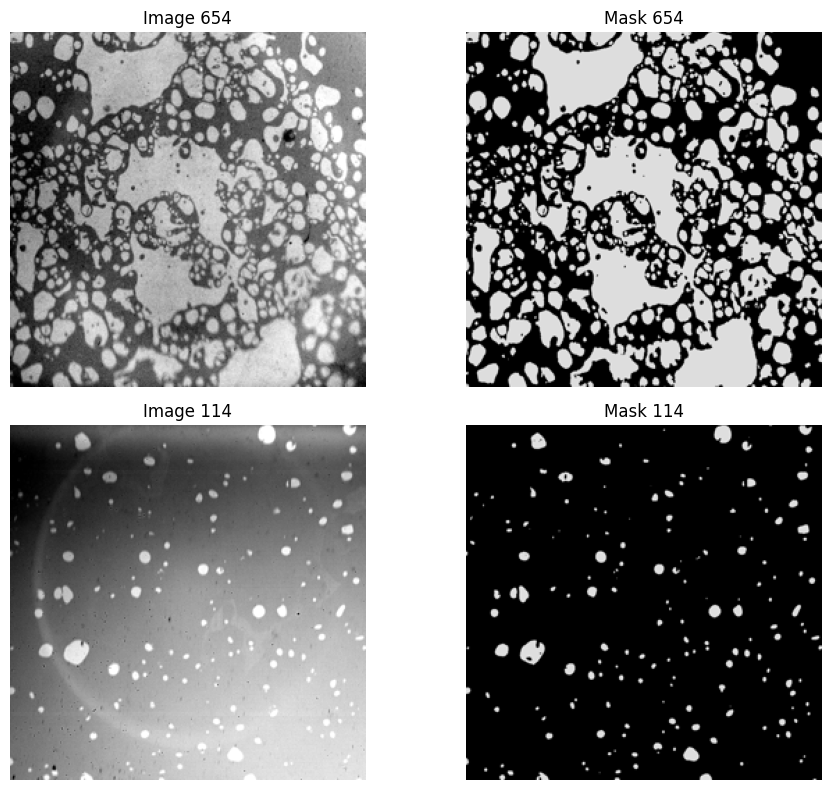

Selected image index: 654
Positive pixel value: 1
Filtered image shape: (4000, 100, 100)
Filtered mask shape: (4000, 100, 100)
Resized image shape: (4000, 256, 256)
Resized mask shape: (4000, 256, 256)
Normalized mask shape: (4000, 256, 256)
Normalized masks range: 0.0 - 1.0


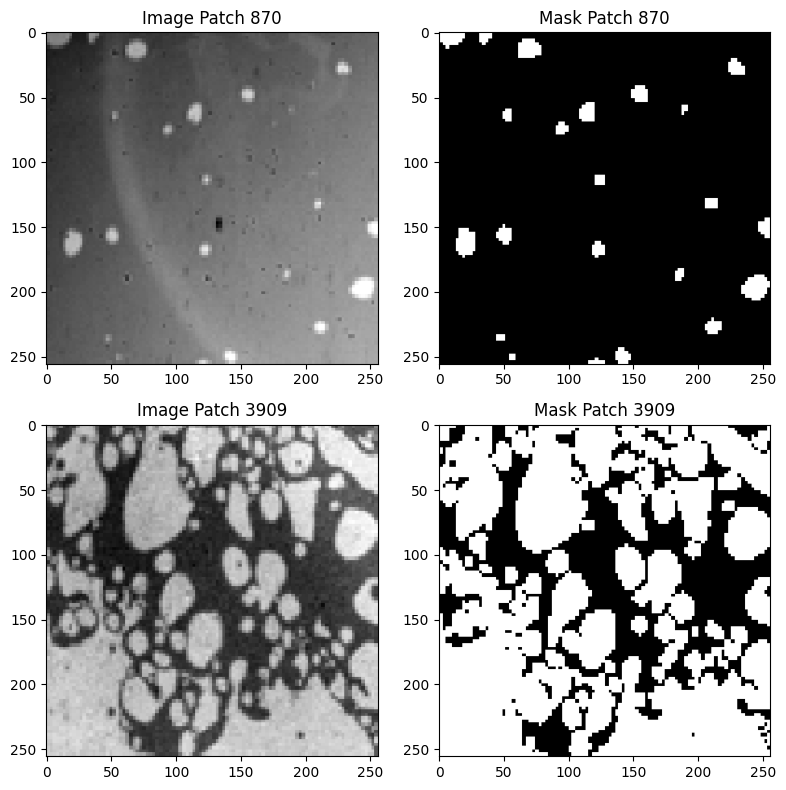

Dataset: Dataset({
    features: ['image', 'label'],
    num_rows: 4000
})
Sample 0 - Image shape: (256, 256), range: 0 - 253
Sample 0 - Mask shape: (256, 256), range: 0.0 - 1.0
Sample 1 - Image shape: (256, 256), range: 42 - 254
Sample 1 - Mask shape: (256, 256), range: 0.0 - 1.0
Sample 2 - Image shape: (256, 256), range: 21 - 255
Sample 2 - Mask shape: (256, 256), range: 0.0 - 1.0
Sample 3 - Image shape: (256, 256), range: 63 - 255
Sample 3 - Mask shape: (256, 256), range: 0.0 - 1.0
Sample 4 - Image shape: (256, 256), range: 0 - 246
Sample 4 - Mask shape: (256, 256), range: 0.0 - 1.0
Sample 5 - Image shape: (256, 256), range: 38 - 255
Sample 5 - Mask shape: (256, 256), range: 0.0 - 1.0
Sample 6 - Image shape: (256, 256), range: 17 - 255
Sample 6 - Mask shape: (256, 256), range: 0.0 - 1.0
Sample 7 - Image shape: (256, 256), range: 63 - 255
Sample 7 - Mask shape: (256, 256), range: 0.0 - 1.0
Sample 8 - Image shape: (256, 256), range: 0 - 193
Sample 8 - Mask shape: (256, 256), range: 0.

In [2]:
import os
import random
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from patchify import patchify
from datasets import Dataset as HFDataset
from PIL import Image

def load_tiff_stack(image_path, mask_path):
    images = tifffile.imread(image_path)
    masks = tifffile.imread(mask_path)
    return images, masks

def visualize_random_images(images, masks, num_samples=2, random_seed=42):
    random.seed(random_seed)
    random_indices = random.sample(range(images.shape[0]), num_samples)
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 8))
    for idx, ax in zip(random_indices, axes):
        ax[0].imshow(images[idx], cmap='gray')
        ax[0].set_title(f'Image {idx}')
        ax[0].axis('off')
        ax[1].imshow(masks[idx], cmap='gray')
        ax[1].set_title(f'Mask {idx}')
        ax[1].axis('off')
    plt.tight_layout()
    plt.show()
    return random_indices[0]

def patchify_images_and_masks(images, masks, patch_size, step):
    image_patches = []
    mask_patches = []
    for img, mask in zip(images, masks):
        img_patches = patchify(img, (patch_size, patch_size), step=step)
        mask_patches_ = patchify(mask, (patch_size, patch_size), step=step)

        img_patches = img_patches.reshape(-1, patch_size, patch_size)
        mask_patches_ = mask_patches_.reshape(-1, patch_size, patch_size)

        image_patches.extend(img_patches)
        mask_patches.extend(mask_patches_)

    return np.array(image_patches), np.array(mask_patches)

def filter_non_empty_patches(images, masks):
    valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
    return images[valid_indices], masks[valid_indices]

def resize_patches(images, masks, target_size):
    resized_images = [np.array(Image.fromarray(img).resize(target_size, Image.NEAREST)) for img in images]
    resized_masks = [np.array(Image.fromarray(mask).resize(target_size, Image.NEAREST)) for mask in masks]
    return np.array(resized_images), np.array(resized_masks)

def normalize_masks(masks):
    return (masks > 0).astype(np.float32)

def visualize_patches(image_patches, mask_patches, num_samples=2):
    if len(image_patches) == 0 or len(mask_patches) == 0:
        print("Image patches or mask patches array is empty. Cannot visualize.")
        return

    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4*num_samples))
    selected_indices = np.random.choice(range(len(image_patches)), num_samples, replace=False)
    for i, idx in enumerate(selected_indices):
        axes[i, 0].imshow(image_patches[idx], cmap='gray')
        axes[i, 0].set_title(f'Image Patch {idx}')
        axes[i, 1].imshow(mask_patches[idx], cmap='gray')
        axes[i, 1].set_title(f'Mask Patch {idx}')
    plt.tight_layout()
    plt.show()

def create_dataset(images, masks):
    dataset_dict = {
        "image": images.tolist(),  # Convert numpy arrays to lists
        "label": masks.tolist(),  # Convert numpy arrays to lists
    }
    return HFDataset.from_dict(dataset_dict)

def main():
    image_path = "/home/ubuntu/train/train.tif"
    mask_path = "/home/ubuntu/train/train_mask.tif"
    patch_size = 100
    step = 100
    target_size = (256, 256)
    random_seed = 42

    images, masks = load_tiff_stack(image_path, mask_path)
    print("Image shape:", images.shape)
    print("Mask shape:", masks.shape)

    selected_index = visualize_random_images(images, masks, random_seed=random_seed)
    print("Selected image index:", selected_index)

    positive_pixel_value = np.unique(masks)[1]
    print("Positive pixel value:", positive_pixel_value)

    image_patches, mask_patches = patchify_images_and_masks(images, masks, patch_size, step)

    filtered_images, filtered_masks = filter_non_empty_patches(image_patches, mask_patches)
    print("Filtered image shape:", filtered_images.shape)
    print("Filtered mask shape:", filtered_masks.shape)

    resized_images, resized_masks = resize_patches(filtered_images, filtered_masks, target_size)
    print("Resized image shape:", resized_images.shape)
    print("Resized mask shape:", resized_masks.shape)

    normalized_masks = normalize_masks(resized_masks)
    print("Normalized mask shape:", normalized_masks.shape)
    print(f"Normalized masks range: {normalized_masks.min()} - {normalized_masks.max()}")

    visualize_patches(resized_images, normalized_masks)

    dataset = create_dataset(resized_images, normalized_masks)
    print("Dataset:", dataset)

    # Check shape and range of features in the dataset
    for i in range(10):
        img = np.array(dataset[i]["image"])  # Convert back to numpy array
        mask = np.array(dataset[i]["label"])  # Convert back to numpy array
        print(f"Sample {i} - Image shape: {img.shape}, range: {img.min()} - {img.max()}")
        print(f"Sample {i} - Mask shape: {mask.shape}, range: {mask.min()} - {mask.max()}")

    return dataset

if __name__ == "__main__":
    dataset = main()

# 3. Training Scripts

## 3.1 Train + Early Stopping

100%|████████████████████| 1600/1600 [08:19<00:00,  3.20it/s]


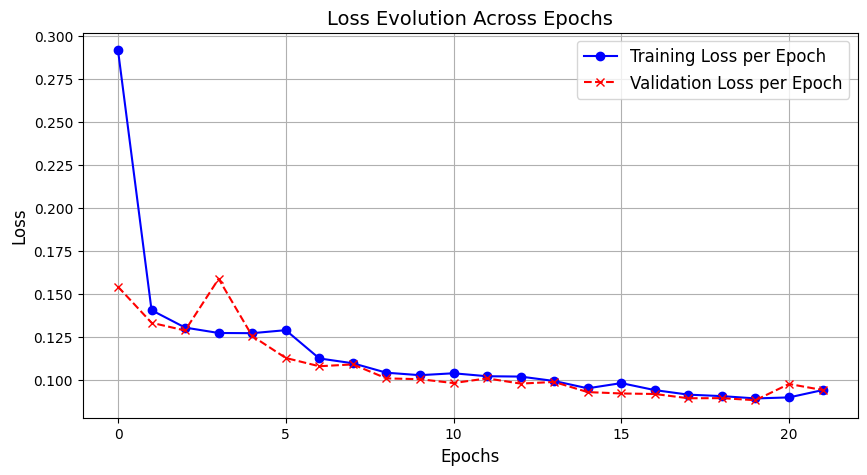

In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SamProcessor, SamModel
from tqdm import tqdm
from statistics import mean
import monai
from PIL import Image
import logging
import random
from torch.cuda.amp import GradScaler, autocast

# Set random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = np.array(item["image"])
        ground_truth_mask = np.array(item["label"])

        if len(image.shape) == 2:
            image = image.reshape(image.shape[0], image.shape[1], 1)

        if image.shape[-1] == 1:
            image = np.repeat(image, 3, axis=-1)

        prompt = self.get_bounding_box(ground_truth_mask)
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt", do_rescale=False)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["ground_truth_mask"] = torch.tensor(ground_truth_mask, dtype=torch.float32).unsqueeze(0)

        return inputs

    def get_bounding_box(self, ground_truth_map):
        y_indices, x_indices = np.where(np.squeeze(ground_truth_map) > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        H, W = np.squeeze(ground_truth_map).shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        return [x_min, y_min, x_max, y_max]

def load_model(model_name):
    model = SamModel.from_pretrained(model_name)
    for name, param in model.named_parameters():
        if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
            param.requires_grad_(False)
    return model

def save_checkpoint(model, optimizer, epoch, losses, val_losses, checkpoint_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'val_losses': val_losses
    }
    torch.save(checkpoint, checkpoint_path)

def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        losses = checkpoint['losses']
        val_losses = checkpoint['val_losses']
        return epoch, losses, val_losses
    else:
        return 0, [], []

def calculate_metrics(pred_masks, true_masks):
    pred_masks = (pred_masks > 0.5).float()
    intersection = (pred_masks * true_masks).sum()
    union = (pred_masks + true_masks).sum() - intersection
    iou = intersection / union
    precision = intersection / pred_masks.sum()
    recall = intersection / true_masks.sum()
    return iou.item(), precision.item(), recall.item()

def validate(model, dataloader, seg_loss, device):
    model.eval()
    val_losses = []
    iou_scores = []
    precision_scores = []
    recall_scores = []
    with torch.no_grad():
        for batch in dataloader:
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks)
            val_losses.append(loss.item())

            iou, precision, recall = calculate_metrics(predicted_masks, ground_truth_masks)
            iou_scores.append(iou)
            precision_scores.append(precision)
            recall_scores.append(recall)

    return mean(val_losses), mean(iou_scores), mean(precision_scores), mean(recall_scores)

def adjust_params(current_epoch, losses, val_losses, checkpoint_interval, early_stop_patience):
    if len(losses) > 1 and len(val_losses) > 1:
        loss_delta = losses[-1] - losses[-2]
        val_loss_delta = val_losses[-1] - val_losses[-2]

        # Adjust checkpoint interval based on training loss delta
        if abs(loss_delta) > 0.01:
            checkpoint_interval = max(1, checkpoint_interval - 1)
        else:
            checkpoint_interval += 1

        # Adjust early stopping patience based on validation loss stability
        if abs(val_loss_delta) < 0.005:
            early_stop_patience = max(1, early_stop_patience - 1)
        else:
            early_stop_patience += 1

    return checkpoint_interval, early_stop_patience

def get_grad_norms(parameters):
    total_norm = 0.0
    for p in parameters:
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

def adjust_grad_clip(grad_norms, grad_clip):
    if grad_norms > 5.0:
        grad_clip = max(0.1, grad_clip * 0.9)
    elif grad_norms < 0.5:
        grad_clip = min(5.0, grad_clip * 1.1)
    return grad_clip

def train(model, train_loader, val_loader, optimizer, seg_loss, device, num_epochs, logger, start_epoch, losses, val_losses, checkpoint_interval, scheduler=None):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop_patience = 10  # Initial value, will be adjusted dynamically
    grad_clip = 1.0  # Initial gradient clipping threshold
    scaler = GradScaler()  # Gradient scaler for automatic mixed precision

    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_losses = []
        grad_norms_list = []
        for batch_idx, batch in enumerate(tqdm(train_loader), 1):
            with autocast():
                outputs = model(pixel_values=batch["pixel_values"].to(device),
                                input_boxes=batch["input_boxes"].to(device),
                                multimask_output=False)

                predicted_masks = outputs.pred_masks.squeeze(1)
                ground_truth_masks = batch["ground_truth_mask"].float().to(device)
                loss = seg_loss(predicted_masks, ground_truth_masks)

            optimizer.zero_grad()
            scaler.scale(loss).backward()

            grad_norms = get_grad_norms(model.parameters())
            grad_norms_list.append(grad_norms)
            grad_clip = adjust_grad_clip(mean(grad_norms_list), grad_clip)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(optimizer)
            scaler.update()

            epoch_losses.append(loss.item())

            if batch_idx % 1600 == 0:
                logger.info(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item()}, Grad Norms: {grad_norms}, Grad Clip: {grad_clip}')

        mean_loss = mean(epoch_losses)
        losses.append(mean_loss)
        logger.info(f'EPOCH: {epoch + 1}/{num_epochs}, Mean Loss: {mean_loss}')

        val_loss, val_iou, val_precision, val_recall = validate(model, val_loader, seg_loss, device)
        val_losses.append(val_loss)
        logger.info(f'EPOCH: {epoch + 1}/{num_epochs}, Val Loss: {val_loss}, IoU: {val_iou}, Precision: {val_precision}, Recall: {val_recall}')

        checkpoint_interval, early_stop_patience = adjust_params(epoch + 1, losses, val_losses, checkpoint_interval, early_stop_patience)

        if epoch % checkpoint_interval == 0:
            save_checkpoint(model, optimizer, epoch + 1, losses, val_losses, "/home/ubuntu/models/videosam_checkpoint.pth")

        if scheduler:
            scheduler.step(val_loss)

        # Early stopping with cooldown
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), "/home/ubuntu/models/videosam_best.pth")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stop_patience:
            logger.info(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss for {early_stop_patience} consecutive epochs")
            break

    return losses, val_losses

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, marker='o', linestyle='-', color='b', label='Training Loss per Epoch')
    plt.plot(val_losses, marker='x', linestyle='--', color='r', label='Validation Loss per Epoch')
    plt.title('Loss Evolution Across Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.savefig('/home/ubuntu/plots/loss_evolution.jpg', dpi=300)
    plt.show()

def main():
    global model, optimizer, current_epoch  # Declare global variables for signal handler access

    # Set up logging
    logging.basicConfig(filename='/home/ubuntu/train.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger()

    # Ensure directories exist
    os.makedirs('/home/ubuntu/plots', exist_ok=True)
    os.makedirs('/home/ubuntu/models', exist_ok=True)

    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

    # Split dataset into training and validation sets
    dataset_length = len(dataset)
    train_length = int(0.8 * dataset_length)
    val_length = dataset_length - train_length
    train_dataset, val_dataset = random_split(dataset, [train_length, val_length])
    
    train_dataset = SAMDataset(dataset=train_dataset, processor=processor)
    val_dataset = SAMDataset(dataset=val_dataset, processor=processor)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, drop_last=False)

    model = load_model("facebook/sam-vit-base")
    optimizer = torch.optim.Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
    seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Optional: Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

    # Load from checkpoint if available
    checkpoint_path = "/home/ubuntu/models/videosam_checkpoint.pth"
    start_epoch, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_path)

    num_epochs = 100
    checkpoint_interval = 1  # Save checkpoint every 1 epoch
    train_losses, val_losses = train(model, train_loader, val_loader, optimizer, seg_loss, device, num_epochs, logger, start_epoch, train_losses, val_losses, checkpoint_interval, scheduler)
    plot_losses(train_losses, val_losses)

    torch.save(model.state_dict(), "/home/ubuntu/models/videosam_base.pth")

if __name__ == "__main__":
    set_seed(42)  # Set seed for reproducibility
    main()

## 3.2 Train + Hyperparameter Tuning

In [7]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SamProcessor, SamModel
from tqdm import tqdm
from statistics import mean
import monai
from PIL import Image
import logging
import random
from torch.cuda.amp import GradScaler, autocast
import optuna
import time

# Set random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = np.array(item["image"])
        ground_truth_mask = np.array(item["label"])

        if len(image.shape) == 2:
            image = image.reshape(image.shape[0], image.shape[1], 1)

        if image.shape[-1] == 1:
            image = np.repeat(image, 3, axis=-1)

        prompt = self.get_bounding_box(ground_truth_mask)
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt", do_rescale=False)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["ground_truth_mask"] = torch.tensor(ground_truth_mask, dtype=torch.float32).unsqueeze(0)

        return inputs

    def get_bounding_box(self, ground_truth_map):
        y_indices, x_indices = np.where(np.squeeze(ground_truth_map) > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        H, W = np.squeeze(ground_truth_map).shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        return [x_min, y_min, x_max, y_max]

def load_model(model_name):
    model = SamModel.from_pretrained(model_name)
    for name, param in model.named_parameters():
        if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
            param.requires_grad_(False)
    return model

def save_checkpoint(model, optimizer, epoch, losses, val_losses, checkpoint_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'val_losses': val_losses
    }
    torch.save(checkpoint, checkpoint_path)

def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        losses = checkpoint['losses']
        val_losses = checkpoint['val_losses']
        return epoch, losses, val_losses
    else:
        return 0, [], []

def calculate_metrics(pred_masks, true_masks):
    pred_masks = (pred_masks > 0.5).float()
    intersection = (pred_masks * true_masks).sum()
    union = (pred_masks + true_masks).sum() - intersection
    iou = intersection / union
    precision = intersection / pred_masks.sum()
    recall = intersection / true_masks.sum()
    return iou.item(), precision.item(), recall.item()

def validate(model, dataloader, seg_loss, device):
    model.eval()
    val_losses = []
    iou_scores = []
    precision_scores = []
    recall_scores = []
    with torch.no_grad():
        for batch in dataloader:
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks)
            val_losses.append(loss.item())

            iou, precision, recall = calculate_metrics(predicted_masks, ground_truth_masks)
            iou_scores.append(iou)
            precision_scores.append(precision)
            recall_scores.append(recall)

    return mean(val_losses), mean(iou_scores), mean(precision_scores), mean(recall_scores)

def adjust_params(current_epoch, losses, val_losses, checkpoint_interval, early_stop_patience):
    if len(losses) > 1 and len(val_losses) > 1:
        loss_delta = losses[-1] - losses[-2]
        val_loss_delta = val_losses[-1] - val_losses[-2]

        # Adjust checkpoint interval based on training loss delta
        if abs(loss_delta) > 0.01:
            checkpoint_interval = max(1, checkpoint_interval - 1)
        else:
            checkpoint_interval += 1

        # Adjust early stopping patience based on validation loss stability
        if abs(val_loss_delta) < 0.005:
            early_stop_patience = max(1, early_stop_patience - 1)
        else:
            early_stop_patience += 1

    return checkpoint_interval, early_stop_patience

def get_grad_norms(parameters):
    total_norm = 0.0
    for p in parameters:
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

def adjust_grad_clip(grad_norms, grad_clip):
    if grad_norms > 5.0:
        grad_clip = max(0.1, grad_clip * 0.9)
    elif grad_norms < 0.5:
        grad_clip = min(5.0, grad_clip * 1.1)
    return grad_clip

def objective(trial):
    start_time = time.time()  # Track the start time of the trial

    # Define hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-6, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_int('batch_size', 4, 16)
    patience = trial.suggest_int('patience', 5, 20)
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    
    model = load_model("facebook/sam-vit-base")
    optimizer = torch.optim.Adam(model.mask_decoder.parameters(), lr=lr, weight_decay=weight_decay)
    seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    # Split dataset into training and validation sets
    dataset_length = len(dataset)
    train_length = int(0.8 * dataset_length)
    val_length = dataset_length - train_length
    train_dataset, val_dataset = random_split(dataset, [train_length, val_length])
    
    train_dataset = SAMDataset(dataset=train_dataset, processor=processor)
    val_dataset = SAMDataset(dataset=val_dataset, processor=processor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    
    # Training loop with early stopping
    num_epochs = 100
    best_val_loss = float('inf')
    epochs_no_improve = 0
    grad_clip = 1.0  # Initialize grad_clip
    scaler = GradScaler()
    train_losses = []
    val_losses = []
    val_iou_scores = []
    val_precision_scores = []
    val_recall_scores = []

    # Log the current trial parameters
    logging.info(f"Starting trial with lr={lr}, weight_decay={weight_decay}, batch_size={batch_size}, patience={patience}")
    
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        logging.info(f"Starting epoch {epoch + 1}/{num_epochs}")
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            with autocast():
                outputs = model(pixel_values=batch["pixel_values"].to(device),
                                input_boxes=batch["input_boxes"].to(device),
                                multimask_output=False)

                predicted_masks = outputs.pred_masks.squeeze(1)
                ground_truth_masks = batch["ground_truth_mask"].float().to(device)
                loss = seg_loss(predicted_masks, ground_truth_masks)

            optimizer.zero_grad()
            scaler.scale(loss).backward()

            grad_norms = get_grad_norms(model.parameters())
            grad_clip = adjust_grad_clip(grad_norms, grad_clip)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(optimizer)
            scaler.update()

            epoch_losses.append(loss.item())

        mean_loss = mean(epoch_losses)
        train_losses.append(mean_loss)
        logging.info(f"Epoch {epoch + 1}/{num_epochs} completed. Training loss: {mean_loss:.4f}")
        
        val_loss, val_iou, val_precision, val_recall = validate(model, val_loader, seg_loss, device)
        val_losses.append(val_loss)
        val_iou_scores.append(val_iou)
        val_precision_scores.append(val_precision)
        val_recall_scores.append(val_recall)
        
        logging.info(f"Validation results - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            logging.info(f"Early stopping at epoch {epoch + 1}/{num_epochs} due to no improvement for {patience} epochs")
            break

    end_time = time.time()  # Track the end time of the trial
    elapsed_time = end_time - start_time
    logging.info(f"Trial completed in {elapsed_time:.2f} seconds with best validation loss: {best_val_loss:.4f}")

    return best_val_loss

def plot_losses_and_metrics(train_losses, val_losses, val_iou, val_precision, val_recall):
    epochs = range(1, len(train_losses) + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot Training and Validation Losses
    axes[0, 0].plot(epochs, train_losses, 'b-', label='Training Loss')
    axes[0, 0].plot(epochs, val_losses, 'r--', label='Validation Loss')
    axes[0, 0].set_title('Loss Evolution Across Epochs')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot IoU Scores
    axes[0, 1].plot(epochs, val_iou, 'g-', label='Validation IoU')
    axes[0, 1].set_title('IoU Scores Across Epochs')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('IoU')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot Precision Scores
    axes[1, 0].plot(epochs, val_precision, 'm-', label='Validation Precision')
    axes[1, 0].set_title('Precision Scores Across Epochs')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot Recall Scores
    axes[1, 1].plot(epochs, val_recall, 'c-', label='Validation Recall')
    axes[1, 1].set_title('Recall Scores Across Epochs')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('/home/ubuntu/plots/losses_and_metrics_evolution.jpg', dpi=300)
    plt.show()

def main():
    global model, optimizer, current_epoch

    # Set up logging
    logging.basicConfig(filename='/home/ubuntu/train.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger()

    # Ensure directories exist
    os.makedirs('/home/ubuntu/plots', exist_ok=True)
    os.makedirs('/home/ubuntu/models', exist_ok=True)

    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

    # Run hyperparameter optimization
    n_trials = 50
    study = optuna.create_study(direction='minimize')
    for trial in range(n_trials):
        logger.info(f"Starting trial {trial + 1}/{n_trials}")
        start_time = time.time()  # Track the start time of the trial
        study.optimize(objective, n_trials=1, catch=(Exception,))
        end_time = time.time()  # Track the end time of the trial
        elapsed_time = end_time - start_time
        logger.info(f"Completed trial {trial + 1}/{n_trials} in {elapsed_time:.2f} seconds")
        logger.info(f"Best validation loss so far: {study.best_value:.4f}")
        remaining_trials = n_trials - (trial + 1)
        logger.info(f"Remaining trials: {remaining_trials}")

    # Print the best hyperparameters
    print("Best hyperparameters:", study.best_params)

    # Train the final model with the best hyperparameters
    best_params = study.best_params
    model = load_model("facebook/sam-vit-base")
    optimizer = torch.optim.Adam(model.mask_decoder.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Split dataset into training and validation sets
    dataset_length = len(dataset)
    train_length = int(0.8 * dataset_length)
    val_length = dataset_length - train_length
    train_dataset, val_dataset = random_split(dataset, [train_length, val_length])
    
    train_dataset = SAMDataset(dataset=train_dataset, processor=processor)
    val_dataset = SAMDataset(dataset=val_dataset, processor=processor)
    
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, drop_last=False)

    # Optional: Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

    # Load from checkpoint if available
    checkpoint_path = "/home/ubuntu/models/videosam_checkpoint.pth"
    start_epoch, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_path)

    num_epochs = 100
    checkpoint_interval = 1  # Save checkpoint every 1 epoch
    train_losses, val_losses, val_iou_scores, val_precision_scores, val_recall_scores = train(model, train_loader, val_loader, optimizer, seg_loss, device, num_epochs, logger, start_epoch, train_losses, val_losses, checkpoint_interval, scheduler)
    plot_losses_and_metrics(train_losses, val_losses, val_iou_scores, val_precision_scores, val_recall_scores)

    torch.save(model.state_dict(), "/home/ubuntu/models/videosam_base.pth")

if __name__ == "__main__":
    set_seed(42)  # Set seed for reproducibility
    main()


[I 2024-06-22 08:19:36,935] A new study created in memory with name: no-name-ab6c34bc-a0a7-43c4-963b-3327fc259f76
Epoch 1/100: 100%|█| 458/458 [07:03<00:00, 
Epoch 2/100: 100%|█| 458/458 [07:00<00:00, 
Epoch 3/100: 100%|█| 458/458 [07:01<00:00, 
Epoch 4/100: 100%|█| 458/458 [07:03<00:00, 
Epoch 5/100:  36%|▎| 164/458 [02:31<04:31, 
[W 2024-06-22 08:59:57,487] Trial 0 failed with parameters: {'lr': 8.743426508495132e-05, 'weight_decay': 0.0008070766414788506, 'batch_size': 7, 'patience': 16} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/ubuntu/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_20137/3392702520.py", line 206, in objective
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
  File "/home/ubuntu/venv/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
  File "/home

KeyboardInterrupt: 

# 4 Inference

## 4.1 Mask Extraction (Single Frame)

/tmp/ipykernel_5715/4256943344.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  videosam_model.load_state_dict(torch.load(videosam_model_path))


Fluid: Water, Grid Boxes: [[[0.0, 0.0, 256.0, 256.0]]]
Input shapes: [torch.Size([1, 3, 1024, 1024]), torch.Size([1, 2]), torch.Size([1, 2]), torch.Size([1, 1, 4])]
Fluid: Water, VideoSAM unique values: [0 1], SAM unique values: [0 1]
Fluid: FC72, Grid Boxes: [[[0.0, 0.0, 256.0, 256.0]]]
Input shapes: [torch.Size([1, 3, 1024, 1024]), torch.Size([1, 2]), torch.Size([1, 2]), torch.Size([1, 1, 4])]
Fluid: FC72, VideoSAM unique values: [0 1], SAM unique values: [0 1]
Fluid: Nitrogen, Grid Boxes: [[[0.0, 0.0, 256.0, 256.0]]]
Input shapes: [torch.Size([1, 3, 1024, 1024]), torch.Size([1, 2]), torch.Size([1, 2]), torch.Size([1, 1, 4])]
Fluid: Nitrogen, VideoSAM unique values: [0 1], SAM unique values: [0 1]
Fluid: Argon, Grid Boxes: [[[0.0, 0.0, 256.0, 256.0]]]
Input shapes: [torch.Size([1, 3, 1024, 1024]), torch.Size([1, 2]), torch.Size([1, 2]), torch.Size([1, 1, 4])]
Fluid: Argon, VideoSAM unique values: [0 1], SAM unique values: [0 1]


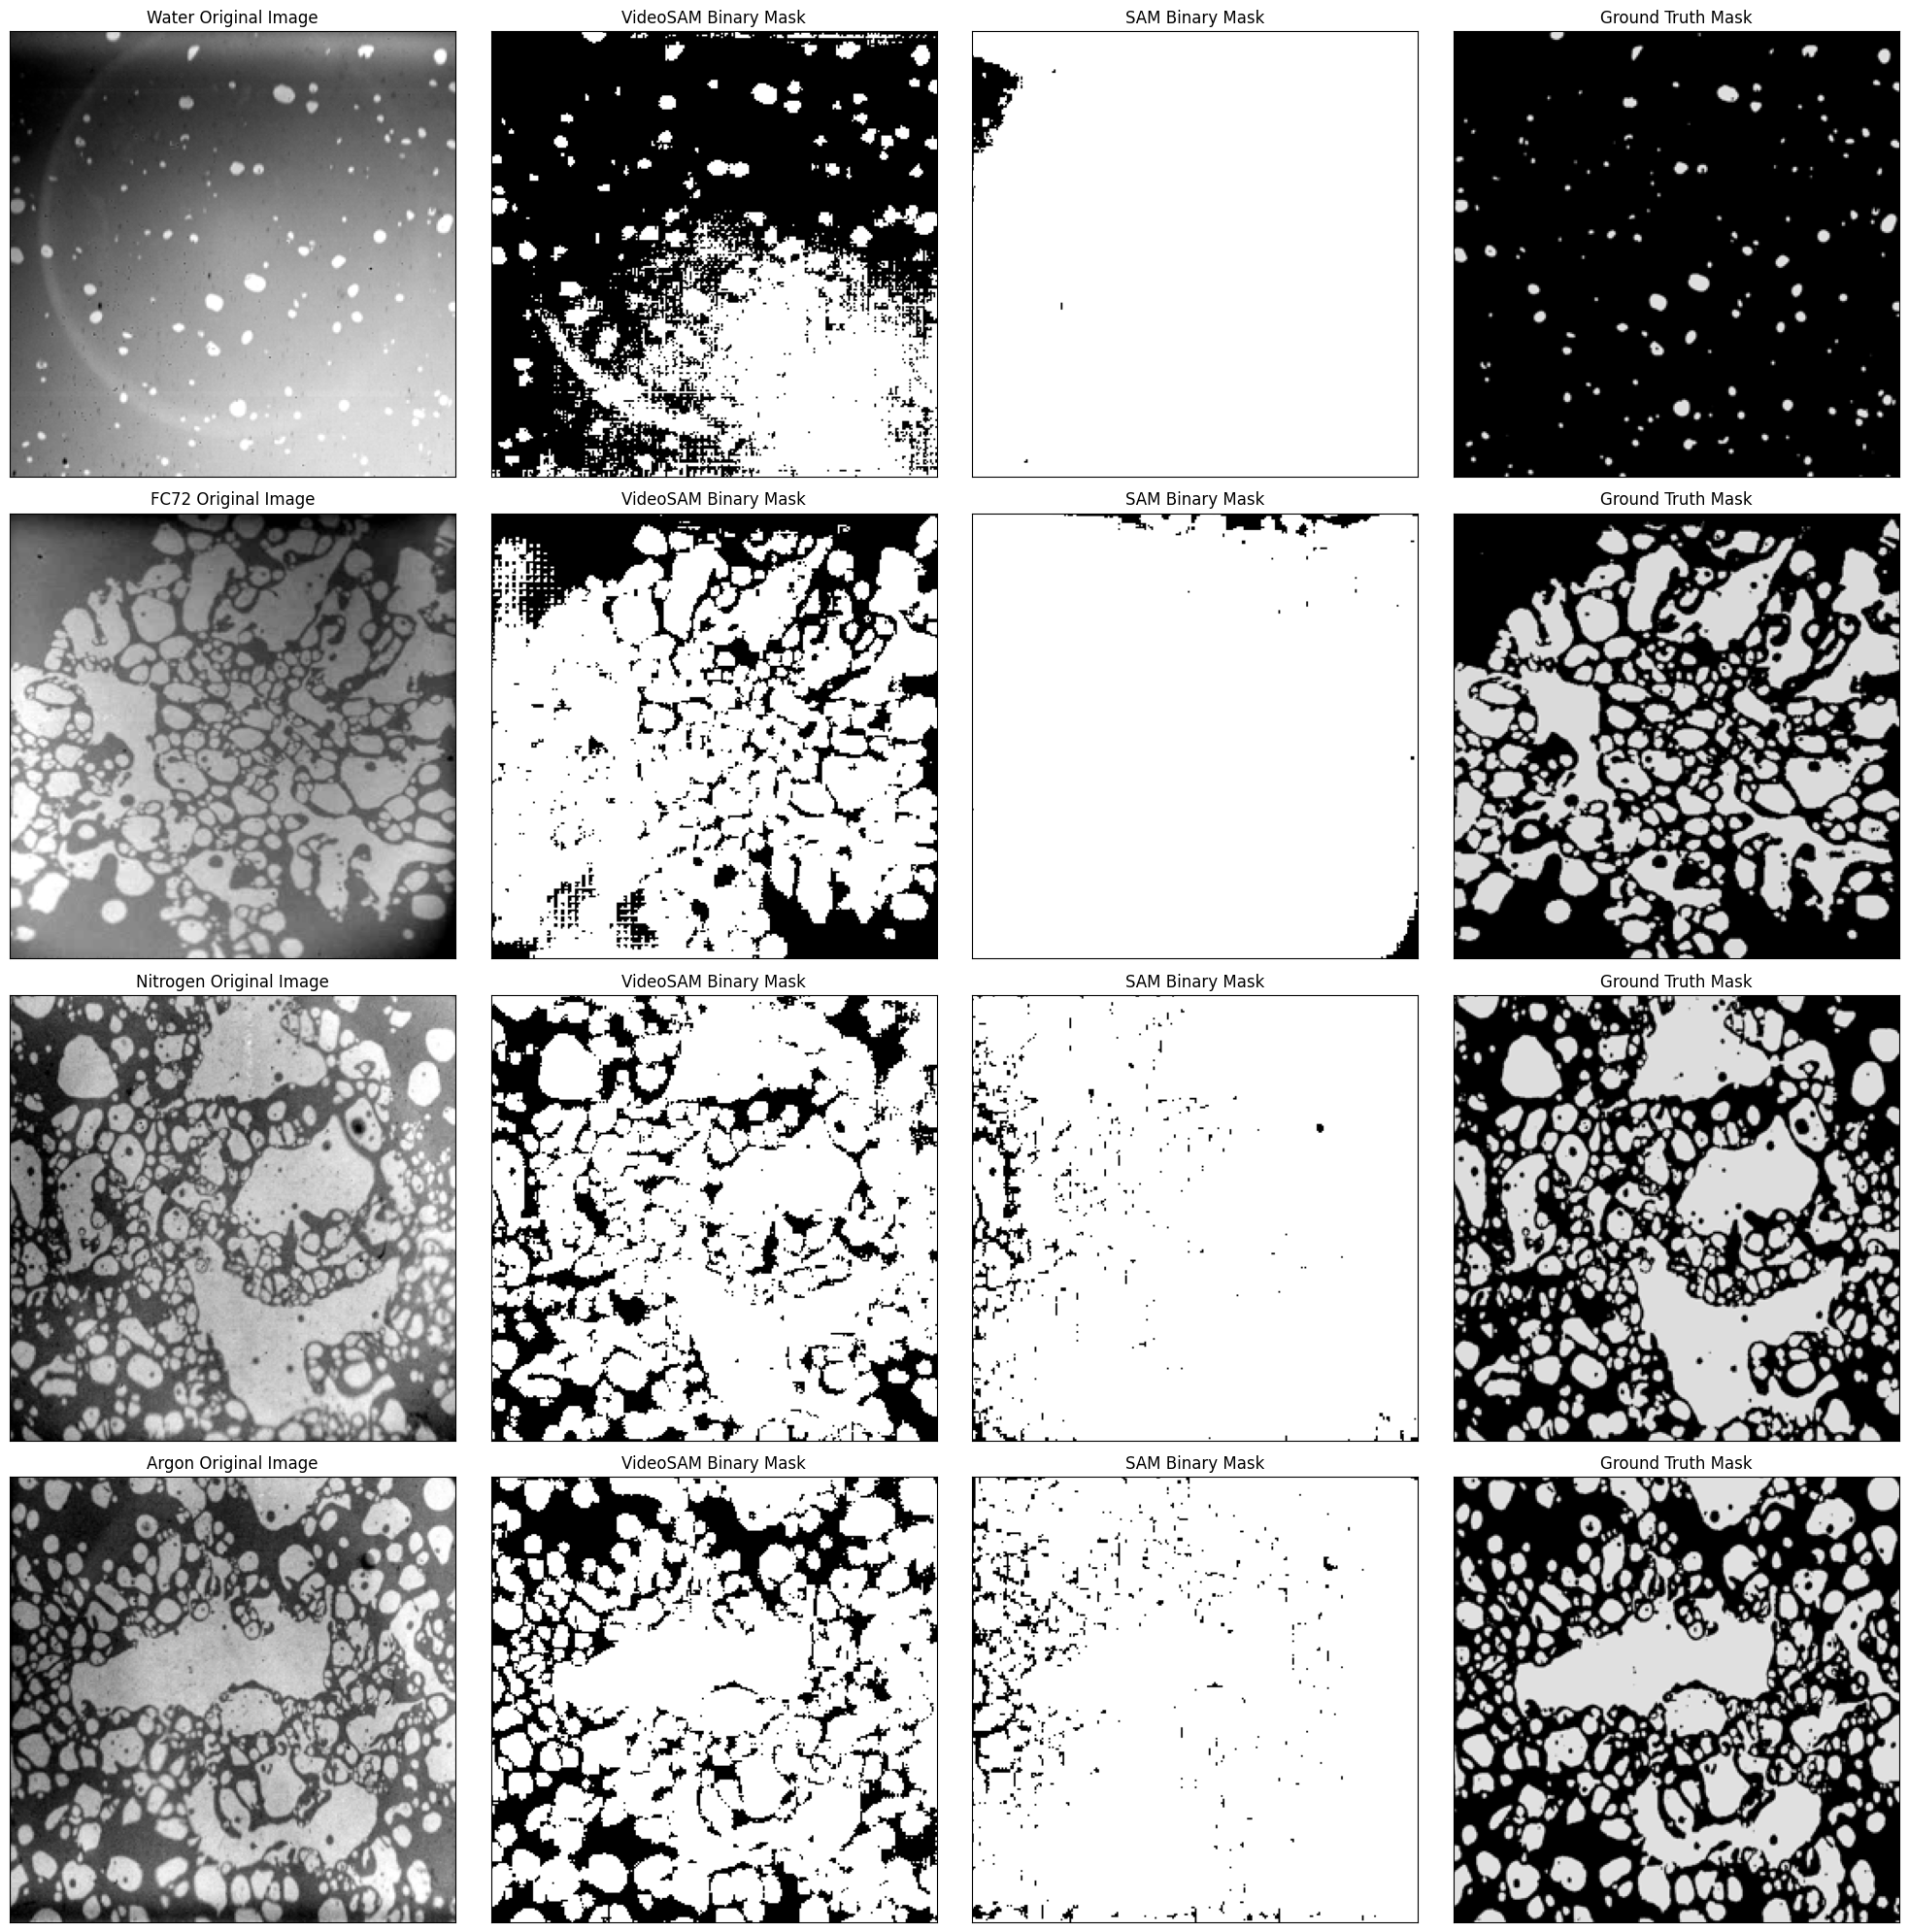

In [14]:
import numpy as np
import torch
import tifffile
import matplotlib.pyplot as plt
from transformers import SamModel, SamProcessor
from torch.utils.data import Dataset, DataLoader
import os

class SAMInferenceDataset(Dataset):
    def __init__(self, images, masks, processor, grid_size=256):
        self.images = images
        self.masks = masks
        self.processor = processor
        self.grid_size = grid_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        image_rgb = np.repeat(image[:, :, np.newaxis], 3, axis=2)  # Convert grayscale to RGB
        grid_boxes = self.get_grid_boxes(image_rgb.shape[0], image_rgb.shape[1], self.grid_size)
        inputs = self.processor(image_rgb, input_boxes=grid_boxes, return_tensors="pt", do_rescale=False)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, mask

    @staticmethod
    def get_grid_boxes(image_height, image_width, grid_size):
        grid_boxes = []
        for y in range(0, image_height, grid_size):
            for x in range(0, image_width, grid_size):
                x_min = x
                x_max = min(x + grid_size, image_width)
                y_min = y
                y_max = min(y + grid_size, image_height)
                grid_boxes.append([[float(x_min), float(y_min), float(x_max), float(y_max)]])
        return grid_boxes

def load_and_prepare_data(image_path, mask_path):
    images = tifffile.imread(image_path)
    masks = tifffile.imread(mask_path)
    return images, masks

def predict(model, inputs):
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
        probabilities = torch.sigmoid(outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()
    return (probabilities > 0.5).astype(np.uint8)

def plot_results(fig, axes, images, titles, row_index):
    for col_index, (image, title) in enumerate(zip(images, titles)):
        ax = axes[row_index, col_index]
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

def stitch_masks(masks, image_shape, grid_size):
    stitched_mask = np.zeros(image_shape, dtype=np.uint8)
    mask_idx = 0
    for y in range(0, image_shape[0], grid_size):
        for x in range(0, image_shape[1], grid_size):
            stitched_mask[y:y+grid_size, x:x+grid_size] = masks[mask_idx]
            mask_idx += 1
    return stitched_mask

def main():
    # Paths to the test images and masks
    image_path = "/home/ubuntu/test/test.tif"
    mask_path = "/home/ubuntu/test/test_mask.tif"
    fluid_names = ["Water", "FC72", "Nitrogen", "Argon"]
    output_dir = "/home/ubuntu/masks"

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Load and prepare the data
    large_test_images, ground_truth_masks = load_and_prepare_data(image_path, mask_path)
    
    # Create the figure for plotting
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))

    # Load models and processor
    videosam_model_path = "/home/ubuntu/models/videosam_base.pth"
    sam_model_name = "facebook/sam-vit-base"
    videosam_model = SamModel.from_pretrained(sam_model_name)
    videosam_model.load_state_dict(torch.load(videosam_model_path))
    sam_model = SamModel.from_pretrained(sam_model_name)
    processor = SamProcessor.from_pretrained(sam_model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    videosam_model.to(device)
    sam_model.to(device)

    # Ensure randomness for each run
    np.random.seed()

    grid_size = 256

    # Create datasets
    start_end_indices = [(i * 250, (i + 1) * 250) for i in range(4)]
    for i, (start_index, end_index) in enumerate(start_end_indices):
        random_frame_index = np.random.randint(start_index, end_index)
        test_image = large_test_images[random_frame_index]
        ground_truth_mask = ground_truth_masks[random_frame_index]
        test_image_rgb = np.repeat(test_image[:, :, np.newaxis], 3, axis=2)

        grid_boxes = SAMInferenceDataset.get_grid_boxes(test_image_rgb.shape[0], test_image_rgb.shape[1], grid_size)
        inputs = processor(test_image_rgb, input_boxes=grid_boxes, return_tensors="pt", do_rescale=False)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Debugging: Print input details
        print(f"Fluid: {fluid_names[i]}, Grid Boxes: {grid_boxes}")
        print(f"Input shapes: {[v.shape for v in inputs.values()]}")

        # Predictions
        videosam_predictions = []
        sam_predictions = []
        for box in grid_boxes:
            single_input = {k: v for k, v in inputs.items()}
            videosam_prediction = predict(videosam_model, single_input)
            sam_prediction = predict(sam_model, single_input)
            videosam_predictions.append(videosam_prediction)
            sam_predictions.append(sam_prediction)

        # Stitch masks
        videosam_stitched_mask = stitch_masks(videosam_predictions, test_image.shape, grid_size)
        sam_stitched_mask = stitch_masks(sam_predictions, test_image.shape, grid_size)

        # Save masks
        np.save(os.path.join(output_dir, f"{fluid_names[i]}_videosam_mask.npy"), videosam_stitched_mask)
        np.save(os.path.join(output_dir, f"{fluid_names[i]}_sam_mask.npy"), sam_stitched_mask)
        np.save(os.path.join(output_dir, f"{fluid_names[i]}_ground_truth_mask.npy"), ground_truth_mask)

        # Debug print to check for blank masks
        print(f"Fluid: {fluid_names[i]}, VideoSAM unique values: {np.unique(videosam_stitched_mask)}, SAM unique values: {np.unique(sam_stitched_mask)}")

        images = [test_image, videosam_stitched_mask, sam_stitched_mask, ground_truth_mask]
        titles = [f"{fluid_names[i]} Original Image", "VideoSAM Binary Mask", "SAM Binary Mask", "Ground Truth Mask"]
        plot_results(fig, axes, images, titles, i)

    plt.tight_layout()
    plt.savefig('/home/ubuntu/plots/visual_comparison_test.jpg', dpi=300)
    plt.show()

if __name__ == "__main__":
    main()


## 4.2 Metrics Evaluation (Single Frame)

/tmp/ipykernel_465823/856709595.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_465823/856709595.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_465823/856709595.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_465823/856709595.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


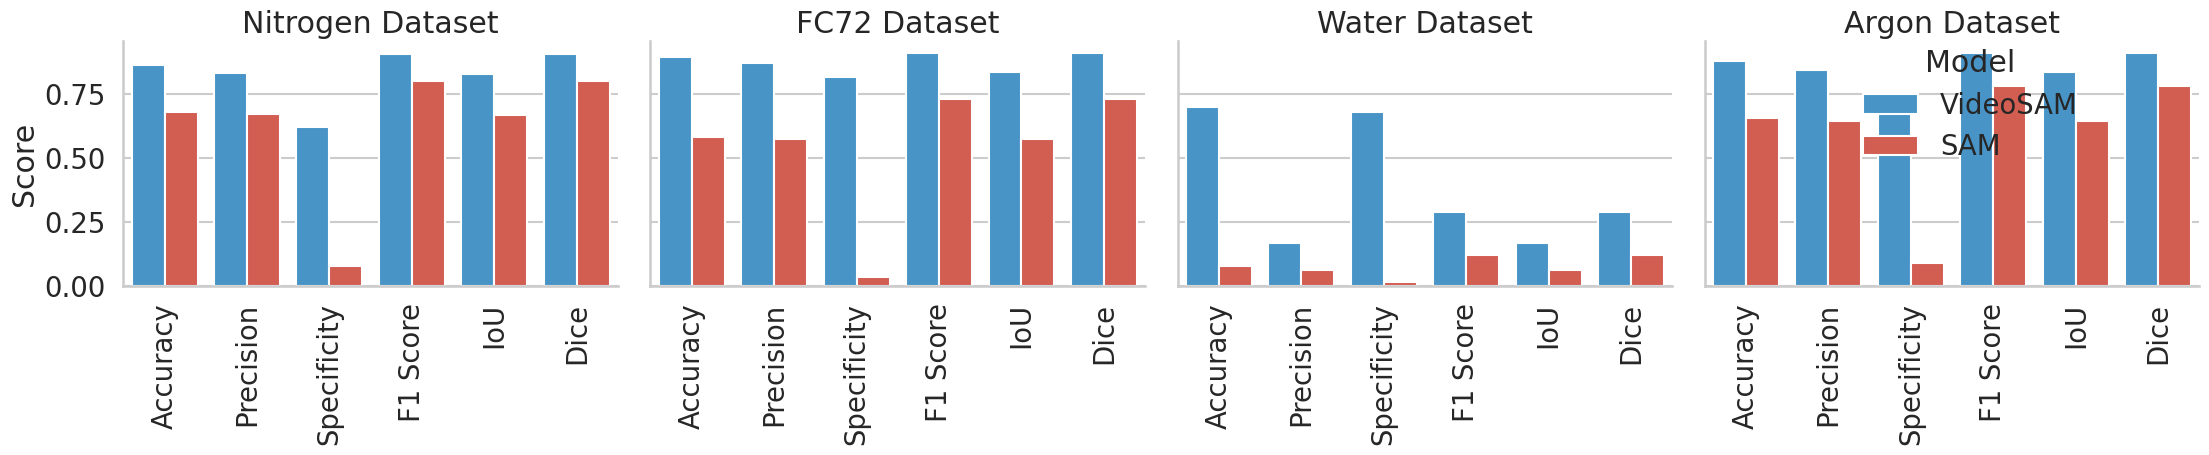

      Fluid     Model  Accuracy  Precision  Specificity  F1 Score       IoU  \
0  Nitrogen  VideoSAM  0.864502   0.832574     0.622169  0.905536  0.827378   
1  Nitrogen       SAM  0.678223   0.671094     0.075222  0.802132  0.669633   
2      FC72  VideoSAM  0.895264   0.871519     0.817168  0.911546  0.837469   
3      FC72       SAM  0.580185   0.573647     0.035241  0.729067  0.573647   
4     Water  VideoSAM  0.698807   0.167888     0.680554  0.286448  0.167166   
5     Water       SAM  0.076996   0.062901     0.016040  0.118350  0.062897   
6     Argon  VideoSAM  0.880661   0.844729     0.698147  0.911943  0.838138   
7     Argon       SAM  0.654816   0.644204     0.086898  0.782823  0.643147   

       Dice  
0  0.905536  
1  0.802132  
2  0.911546  
3  0.729067  
4  0.286448  
5  0.118350  
6  0.911942  
7  0.782823  


Fluid     Model  Accuracy  Precision  Specificity  F1 Score       IoU  \
0  Nitrogen  VideoSAM  0.864502   0.832574     0.622169  0.905536  0.827378   
1  Nitrogen       SAM  0.678223   0.671094     0.075222  0.802132  0.669633   
2      FC72  VideoSAM  0.895264   0.871519     0.817168  0.911546  0.837469   
3      FC72       SAM  0.580185   0.573647     0.035241  0.729067  0.573647   
4     Water  VideoSAM  0.698807   0.167888     0.680554  0.286448  0.167166   
5     Water       SAM  0.076996   0.062901     0.016040  0.118350  0.062897   
6     Argon  VideoSAM  0.880661   0.844729     0.698147  0.911943  0.838138   
7     Argon       SAM  0.654816   0.644204     0.086898  0.782823  0.643147   

       Dice  
0  0.905536  
1  0.802132  
2  0.911546  
3  0.729067  
4  0.286448  
5  0.118350  
6  0.911942  
7  0.782823

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix

def calculate_specificity(y_true, y_pred):
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def calculate_dice_coefficient(y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    return 2 * (precision * recall) / (precision + recall + 1e-7) if (precision + recall) > 0 else 0

def load_masks(fluid_name, base_dir):
    videosam_mask = np.load(os.path.join(base_dir, f"{fluid_name}_videosam_mask.npy"))
    sam_mask = np.load(os.path.join(base_dir, f"{fluid_name}_sam_mask.npy"))
    gt_mask = np.load(os.path.join(base_dir, f"{fluid_name}_ground_truth_mask.npy"))
    return videosam_mask, sam_mask, gt_mask

def binarize_masks(mask):
    return (mask > 0.5).astype(np.uint8)

def calculate_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Specificity': calculate_specificity(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred, zero_division=0),
        'IoU': jaccard_score(y_true, y_pred, zero_division=0),
        'Dice': calculate_dice_coefficient(y_true, y_pred)
    }

def plot_all_metrics(results, output_path_base):
    sns.set(style="whitegrid")
    sns.set_context("talk", font_scale=1.2)
    custom_palette = ["#3498db", "#e74c3c"]
    sns.set_palette(custom_palette)

    metrics = ['Accuracy', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'Dice']
    data = {'Fluid': [], 'Metric': [], 'Value': [], 'Model': []}

    for fluid in results:
        for metric in metrics:
            data['Fluid'].extend([fluid] * 2)
            data['Metric'].extend([metric] * 2)
            data['Value'].extend([results[fluid]['VideoSAM'][metric], results[fluid]['SAM'][metric]])
            data['Model'].extend(['VideoSAM', 'SAM'])
            
    df = pd.DataFrame(data)
    g = sns.catplot(x='Metric', y='Value', hue='Model', col='Fluid', data=df, kind='bar', height=5, aspect=1, legend_out=True)
    g.set_titles("{col_name} Dataset")
    g.set_axis_labels("", "Score")

    for ax in g.axes.flat:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    g.fig.subplots_adjust(top=0.9)
    g.fig.legends[0].set_title('Model')
    g.fig.legends[0].set_bbox_to_anchor((0.94, 0.7))

    g.fig.tight_layout()
    
    output_path_png = f"{output_path_base}.png"
    output_path_pdf = f"{output_path_base}.pdf"
    
    plt.savefig(output_path_png, dpi=300)
    plt.savefig(output_path_pdf)
    plt.show()

def create_table(results, output_path):
    metrics = ['Accuracy', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'Dice']
    table_data = []

    for fluid in results:
        for model in ['VideoSAM', 'SAM']:
            row = [fluid, model]
            for metric in metrics:
                row.append(results[fluid][model][metric])
            table_data.append(row)

    df = pd.DataFrame(table_data, columns=['Fluid', 'Model'] + metrics)
    df.to_csv(output_path, index=False)
    print(df)
    return df

def main():
    base_dir = "/home/ubuntu/masks"
    fluid_names = ["Nitrogen", "FC72", "Water", "Argon"]
    results = {fluid: {'VideoSAM': {}, 'SAM': {}} for fluid in fluid_names}

    for fluid in fluid_names:
        videosam_mask, sam_mask, gt_mask = load_masks(fluid, base_dir)
        
        # Binarize masks
        videosam_mask = binarize_masks(videosam_mask)
        sam_mask = binarize_masks(sam_mask)
        gt_mask = binarize_masks(gt_mask)
        
        results[fluid]['VideoSAM'] = calculate_metrics(gt_mask.flatten(), videosam_mask.flatten())
        results[fluid]['SAM'] = calculate_metrics(gt_mask.flatten(), sam_mask.flatten())

    output_path_base = '/home/ubuntu/plots/metrics_comparison_all'
    plot_all_metrics(results, output_path_base)

    table_output_path = '/home/ubuntu/plots/metrics_comparison_table.csv'
    metrics_table = create_table(results, table_output_path)

    return metrics_table

if __name__ == "__main__":
    metrics_table = main()
    display(metrics_table)


## 4.1 Mask Extraction (Composite Frames)

In [18]:
import numpy as np
import torch
import tifffile
from transformers import SamModel, SamProcessor
import h5py
import os
import logging
from tqdm.notebook import tqdm

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class SAMInferenceDataset:
    @staticmethod
    def get_grid_boxes(image_height, image_width, grid_size):
        grid_boxes = []
        for y in range(0, image_height, grid_size):
            for x in range(0, image_width, grid_size):
                x_min = x
                x_max = min(x + grid_size, image_width)
                y_min = y
                y_max = min(y + grid_size, image_height)
                grid_boxes.append([[float(x_min), float(y_min), float(x_max), float(y_max)]])
        return grid_boxes

def load_and_prepare_data(image_path, mask_path):
    try:
        images = tifffile.imread(image_path)
        masks = tifffile.imread(mask_path)
        return images, masks
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        raise

def predict(model, inputs):
    model.eval()
    with torch.no_grad():
        try:
            outputs = model(**inputs, multimask_output=False)
            probabilities = torch.sigmoid(outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()
            return (probabilities > 0.5).astype(np.uint8)
        except Exception as e:
            logging.error(f"Error during prediction: {e}")
            raise

def stitch_masks(masks, image_shape, grid_size):
    stitched_mask = np.zeros(image_shape, dtype=np.uint8)
    mask_idx = 0
    for y in range(0, image_shape[0], grid_size):
        for x in range(0, image_shape[1], grid_size):
            stitched_mask[y:y+grid_size, x:x+grid_size] = masks[mask_idx]
            mask_idx += 1
    return stitched_mask

def main():
    # Paths to the test images and masks
    image_path = "/home/ubuntu/test/test.tif"
    mask_path = "/home/ubuntu/test/test_mask.tif"
    fluid_names = ["Water", "FC72", "Nitrogen", "Argon"]
    output_dir = "/home/ubuntu/masks"
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Load and prepare the data
    large_test_images, ground_truth_masks = load_and_prepare_data(image_path, mask_path)
    logging.info("Data loaded successfully")

    # Load models and processor
    videosam_model_path = "/home/ubuntu/models/videosam_base.pth"
    sam_model_name = "facebook/sam-vit-base"
    videosam_model = SamModel.from_pretrained(sam_model_name)
    videosam_model.load_state_dict(torch.load(videosam_model_path))
    sam_model = SamModel.from_pretrained(sam_model_name)
    processor = SamProcessor.from_pretrained(sam_model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    videosam_model.to(device)
    sam_model.to(device)
    logging.info("Models loaded and moved to device")

    grid_size = 256

    # Open an HDF5 file for storing the masks
    with h5py.File(os.path.join(output_dir, 'segmentation_masks.h5'), 'w') as h5f:
        for frame_index in tqdm(range(1000), desc="Processing frames"):
            try:
                fluid_index = frame_index // 250
                fluid_name = fluid_names[fluid_index]
                
                logging.info(f"Processing frame {frame_index} for fluid {fluid_name}")

                test_image = large_test_images[frame_index]
                ground_truth_mask = ground_truth_masks[frame_index]
                test_image_rgb = np.repeat(test_image[:, :, np.newaxis], 3, axis=2)

                grid_boxes = SAMInferenceDataset.get_grid_boxes(test_image_rgb.shape[0], test_image_rgb.shape[1], grid_size)
                inputs = processor(test_image_rgb, input_boxes=grid_boxes, return_tensors="pt", do_rescale=False)
                inputs = {k: v.to(device) for k, v in inputs.items()}

                # Predictions
                videosam_predictions = []
                sam_predictions = []
                for box in grid_boxes:
                    single_input = {k: v for k, v in inputs.items()}
                    videosam_prediction = predict(videosam_model, single_input)
                    sam_prediction = predict(sam_model, single_input)
                    videosam_predictions.append(videosam_prediction)
                    sam_predictions.append(sam_prediction)

                # Stitch masks
                videosam_stitched_mask = stitch_masks(videosam_predictions, test_image.shape, grid_size)
                sam_stitched_mask = stitch_masks(sam_predictions, test_image.shape, grid_size)

                # Save masks to HDF5 file
                h5f.create_dataset(f"{fluid_name}/videosam_mask_{frame_index % 250}", data=videosam_stitched_mask, compression="gzip")
                h5f.create_dataset(f"{fluid_name}/sam_mask_{frame_index % 250}", data=sam_stitched_mask, compression="gzip")
                h5f.create_dataset(f"{fluid_name}/ground_truth_mask_{frame_index % 250}", data=ground_truth_mask, compression="gzip")
                
                logging.info(f"Processed and saved masks for frame {frame_index}")
            except Exception as e:
                logging.error(f"Error processing frame {frame_index}: {e}")

if __name__ == "__main__":
    main()


2024-06-17 16:03:27,053 - INFO - Data loaded successfully
2024-06-17 16:03:27,955 - INFO - Models loaded and moved to device


Processing frames:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-06-17 16:03:27,964 - INFO - Processing frame 0 for fluid Water
2024-06-17 16:03:28,338 - INFO - Processed and saved masks for frame 0
2024-06-17 16:03:28,340 - INFO - Processing frame 1 for fluid Water
2024-06-17 16:03:28,744 - INFO - Processed and saved masks for frame 1
2024-06-17 16:03:28,746 - INFO - Processing frame 2 for fluid Water
2024-06-17 16:03:29,147 - INFO - Processed and saved masks for frame 2
2024-06-17 16:03:29,148 - INFO - Processing frame 3 for fluid Water
2024-06-17 16:03:29,527 - INFO - Processed and saved masks for frame 3
2024-06-17 16:03:29,529 - INFO - Processing frame 4 for fluid Water
2024-06-17 16:03:29,889 - INFO - Processed and saved masks for frame 4
2024-06-17 16:03:29,890 - INFO - Processing frame 5 for fluid Water
2024-06-17 16:03:30,268 - INFO - Processed and saved masks for frame 5
2024-06-17 16:03:30,270 - INFO - Processing frame 6 for fluid Water
2024-06-17 16:03:30,695 - INFO - Processed and saved masks for frame 6
2024-06-17 16:03:30,697 - I

## 4.3 Metrics Evaluation (Composite Frames)

Processing Water:   0%|          | 0/250 [00:00<?, ?it/s]

Processing FC72:   0%|          | 0/250 [00:00<?, ?it/s]

Processing Nitrogen:   0%|          | 0/250 [00:00<?, ?it/s]

Processing Argon:   0%|          | 0/250 [00:00<?, ?it/s]

Metrics Summary:
Fluid: Water
  Model: VideoSAM
    Metric: IoU - {'Mean': 0.1894442863990126, 'Min': 0.04721030042918455, 'Max': 0.4289608891685016, 'StdDev': 0.061376049016787775}
    Metric: F1 Score - {'Mean': 0.3142521902548969, 'Min': 0.09016393442622951, 'Max': 0.600381567361315, 'StdDev': 0.08349113655647103}
  Model: SAM
    Metric: IoU - {'Mean': 0.06198749230485768, 'Min': 0.020162099575453493, 'Max': 0.08355511542984465, 'StdDev': 0.011971027014052437}
    Metric: F1 Score - {'Mean': 0.11649566569156403, 'Min': 0.03952724686369758, 'Max': 0.15422402467584395, 'StdDev': 0.021559261712496714}
Fluid: FC72
  Model: VideoSAM
    Metric: IoU - {'Mean': 0.7996551869787615, 'Min': 0.7198280093456109, 'Max': 0.8533755529235455, 'StdDev': 0.0240624180974366}
    Metric: F1 Score - {'Mean': 0.8884764675097442, 'Min': 0.837093017946025, 'Max': 0.9208878919088112, 'StdDev': 0.014925956939948611}
  Model: SAM
    Metric: IoU - {'Mean': 0.5721167317613916, 'Min': 0.5606739309019328, 'Max'

/tmp/ipykernel_3308/2110903671.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3308/2110903671.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3308/2110903671.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3308/2110903671.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


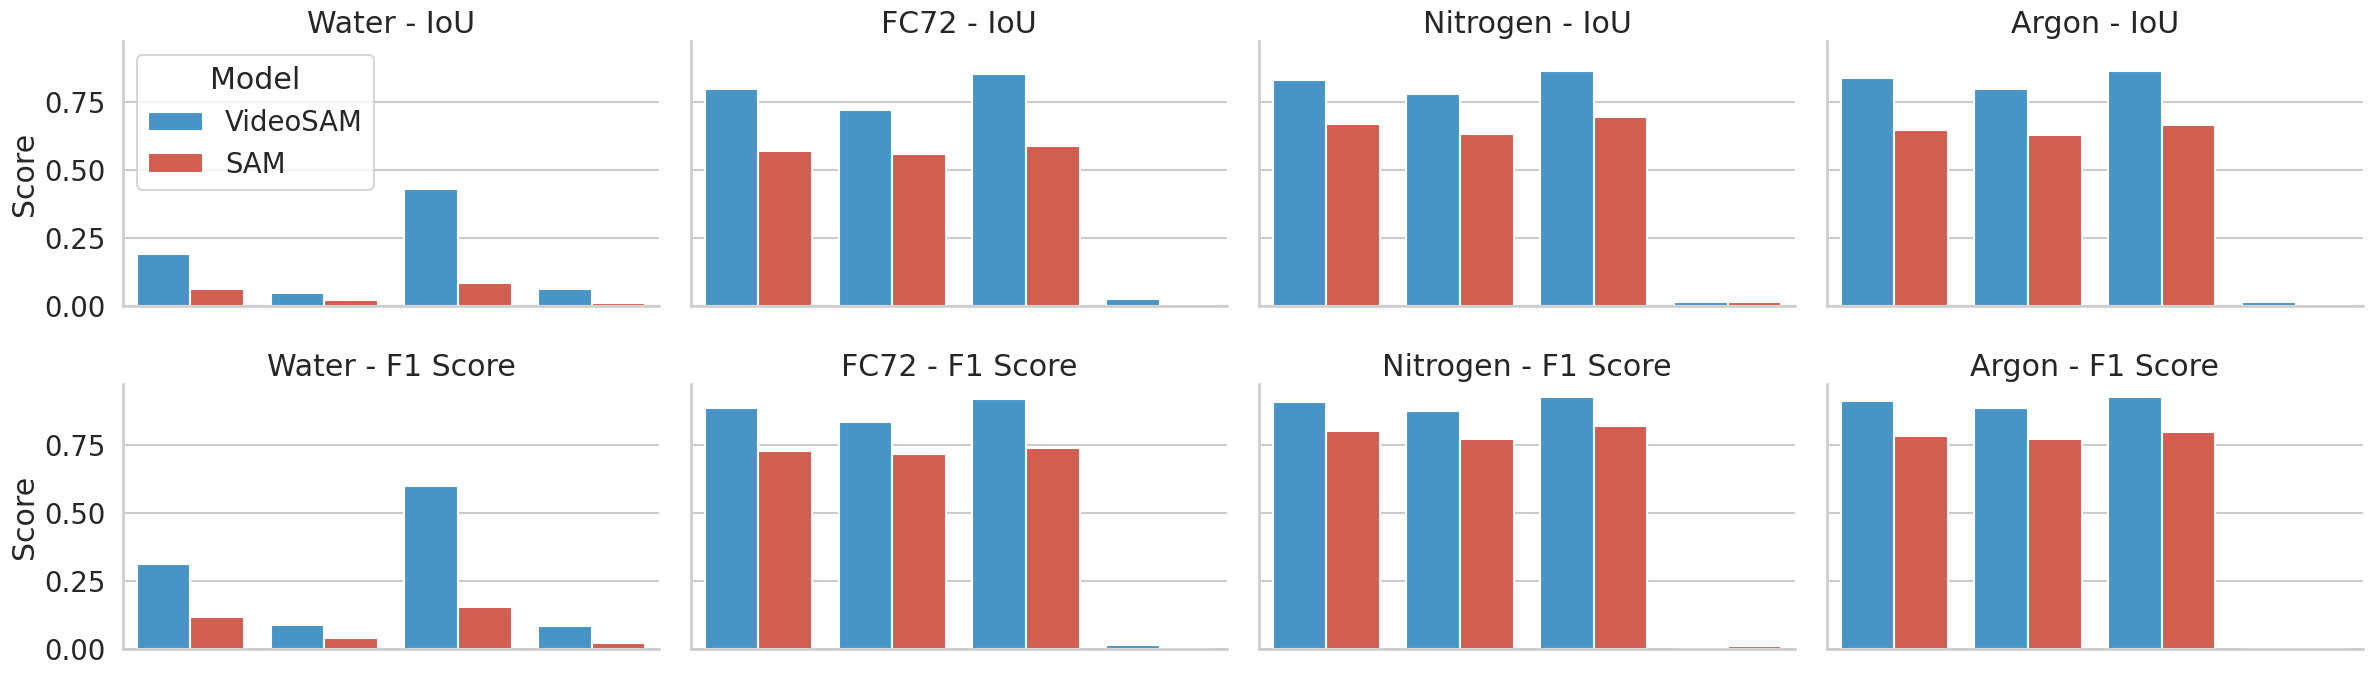

      Fluid  VideoSAM_IoU_Mean  VideoSAM_IoU_Min  VideoSAM_IoU_Max  \
0     Water           0.189444          0.047210          0.428961   
1      FC72           0.799655          0.719828          0.853376   
2  Nitrogen           0.831651          0.781046          0.863867   
3     Argon           0.838407          0.798287          0.865698   

   VideoSAM_IoU_StdDev  VideoSAM_F1 Score_Mean  VideoSAM_F1 Score_Min  \
0             0.061376                0.314252               0.090164   
1             0.024062                0.888476               0.837093   
2             0.013806                0.908027               0.877065   
3             0.013703                0.912041               0.887831   

   VideoSAM_F1 Score_Max  VideoSAM_F1 Score_StdDev  SAM_IoU_Mean  SAM_IoU_Min  \
0               0.600382                  0.083491      0.061987     0.020162   
1               0.920888                  0.014926      0.572117     0.560674   
2               0.926962                

Fluid  VideoSAM_IoU_Mean  VideoSAM_IoU_Min  VideoSAM_IoU_Max  \
0     Water           0.189444          0.047210          0.428961   
1      FC72           0.799655          0.719828          0.853376   
2  Nitrogen           0.831651          0.781046          0.863867   
3     Argon           0.838407          0.798287          0.865698   

   VideoSAM_IoU_StdDev  VideoSAM_F1 Score_Mean  VideoSAM_F1 Score_Min  \
0             0.061376                0.314252               0.090164   
1             0.024062                0.888476               0.837093   
2             0.013806                0.908027               0.877065   
3             0.013703                0.912041               0.887831   

   VideoSAM_F1 Score_Max  VideoSAM_F1 Score_StdDev  SAM_IoU_Mean  SAM_IoU_Min  \
0               0.600382                  0.083491      0.061987     0.020162   
1               0.920888                  0.014926      0.572117     0.560674   
2               0.926962                  0.008242      0.670198     0.632691   
3               0.928015                  0.008148      0.646440     0.629313   

   SAM_IoU_Max  SAM_IoU_StdDev  SAM_F1 Score_Mean  SAM_F1 Score_Min  \
0     0.083555        0.011971           0.116496          0.039527   
1     0.588887        0.006505           0.727808          0.718502   
2     0.695569        0.013049           0.802464          0.775029   
3     0.666741        0.008579           0.785225          0.772489   

   SAM_F1 Score_Max  SAM_F1 Score_StdDev  
0          0.154224             0.021559  
1          0.741257             0.005245  
2          0.820455             0.009394  
3          0.800053             0.006322

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from sklearn.metrics import f1_score, jaccard_score
from tqdm.notebook import tqdm

def load_masks(fluid_name, frame_index, h5f):
    try:
        videosam_mask = h5f[f"{fluid_name}/videosam_mask_{frame_index}"][:]
    except KeyError:
        videosam_mask = None

    try:
        sam_mask = h5f[f"{fluid_name}/sam_mask_{frame_index}"][:]
    except KeyError:
        sam_mask = None

    try:
        gt_mask = h5f[f"{fluid_name}/ground_truth_mask_{frame_index}"][:]
    except KeyError:
        gt_mask = None

    return videosam_mask, sam_mask, gt_mask

def binarize_masks(mask):
    return (mask > 0.5).astype(np.uint8) if mask is not None else None

def calculate_metrics(y_true, y_pred):
    if y_true is None or y_pred is None:
        return {'IoU': None, 'F1 Score': None}
    return {
        'IoU': jaccard_score(y_true, y_pred, zero_division=0),
        'F1 Score': f1_score(y_true, y_pred, zero_division=0)
    }

def summarize_metrics(metrics_list):
    summary = {}
    for metric in metrics_list[0]:
        values = [metrics[metric] for metrics in metrics_list if metrics[metric] is not None]
        summary[metric] = {
            'Mean': np.mean(values) if values else 0,
            'Min': np.min(values) if values else 0,
            'Max': np.max(values) if values else 0,
            'StdDev': np.std(values) if values else 0
        }
    return summary

def plot_metrics_summary(metrics_summary, output_path_base):
    sns.set(style="whitegrid")
    sns.set_context("talk", font_scale=1.2)
    custom_palette = ["#3498db", "#e74c3c"]
    sns.set_palette(custom_palette)

    metrics = list(metrics_summary[next(iter(metrics_summary))]['VideoSAM'].keys())
    data = {'Fluid': [], 'Metric': [], 'Value': [], 'Model': [], 'Statistic': []}

    for fluid in metrics_summary:
        for model in ['VideoSAM', 'SAM']:
            for metric in metrics:
                for stat in ['Mean', 'Min', 'Max', 'StdDev']:
                    value = metrics_summary[fluid][model][metric][stat]
                    if value is not None:
                        data['Fluid'].append(fluid)
                        data['Metric'].append(metric)
                        data['Value'].append(value)
                        data['Model'].append(model)
                        data['Statistic'].append(stat)

    df = pd.DataFrame(data)
    g = sns.catplot(x='Statistic', y='Value', hue='Model', col='Fluid', row='Metric', data=df, kind='bar', height=4, aspect=1.5, legend_out=False)
    g.set_titles("{col_name} - {row_name}")
    g.set_axis_labels("", "Score")

    for ax in g.axes.flat:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    g.fig.subplots_adjust(top=0.9)
    g.add_legend(title='Model')

    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_path_base), exist_ok=True)
    
    output_path_png = f"{output_path_base}.png"
    output_path_pdf = f"{output_path_base}.pdf"
    
    plt.savefig(output_path_png, dpi=300)
    plt.savefig(output_path_pdf)
    plt.show()

def create_summary_table(metrics_summary, output_path):
    metrics = list(metrics_summary[next(iter(metrics_summary))]['VideoSAM'].keys())
    table_data = []

    for fluid in metrics_summary:
        row = [fluid]
        for model in ['VideoSAM', 'SAM']:
            for metric in metrics:
                stats = metrics_summary[fluid][model][metric]
                row.extend([stats['Mean'], stats['Min'], stats['Max'], stats['StdDev']])
        table_data.append(row)

    columns = ['Fluid']
    for model in ['VideoSAM', 'SAM']:
        for metric in metrics:
            columns.extend([f'{model}_{metric}_Mean', f'{model}_{metric}_Min', f'{model}_{metric}_Max', f'{model}_{metric}_StdDev'])

    df = pd.DataFrame(table_data, columns=columns)
    
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    df.to_csv(output_path, index=False)
    print(df)
    return df

def main():
    base_dir = "/home/ubuntu/masks"
    fluid_names = ["Water", "FC72", "Nitrogen", "Argon"]
    results = {fluid: {'VideoSAM': [], 'SAM': []} for fluid in fluid_names}

    with h5py.File(os.path.join(base_dir, 'segmentation_masks.h5'), 'r') as h5f:
        for fluid in fluid_names:
            for frame_index in tqdm(range(250), desc=f"Processing {fluid}"):
                videosam_mask, sam_mask, gt_mask = load_masks(fluid, frame_index, h5f)
                
                # Binarize masks
                videosam_mask = binarize_masks(videosam_mask)
                sam_mask = binarize_masks(sam_mask)
                gt_mask = binarize_masks(gt_mask)
                
                results[fluid]['VideoSAM'].append(calculate_metrics(gt_mask.flatten() if gt_mask is not None else None,
                                                                    videosam_mask.flatten() if videosam_mask is not None else None))
                results[fluid]['SAM'].append(calculate_metrics(gt_mask.flatten() if gt_mask is not None else None,
                                                               sam_mask.flatten() if sam_mask is not None else None))

    metrics_summary = {fluid: {'VideoSAM': summarize_metrics(results[fluid]['VideoSAM']),
                               'SAM': summarize_metrics(results[fluid]['SAM'])} for fluid in fluid_names}

    # Print metrics_summary to debug
    print("Metrics Summary:")
    for fluid, summary in metrics_summary.items():
        print(f"Fluid: {fluid}")
        for model, metrics in summary.items():
            print(f"  Model: {model}")
            for metric, values in metrics.items():
                print(f"    Metric: {metric} - {values}")

    output_path_base = '/home/ubuntu/plots/metrics_comparison_summary'
    plot_metrics_summary(metrics_summary, output_path_base)

    table_output_path = '/home/ubuntu/plots/metrics_comparison_summary_table.csv'
    summary_table = create_summary_table(metrics_summary, table_output_path)

    return summary_table

if __name__ == "__main__":
    summary_table = main()
    display(summary_table)


# 5. Training Script + Different Strategies

In [8]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SamProcessor, SamModel
from tqdm.notebook import tqdm
from statistics import mean
import monai
from transformers import AdamW
from peft import LoraConfig, get_peft_model
import logging
import time

class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = np.array(item["image"])
        ground_truth_mask = np.array(item["label"])
        image = np.repeat(image.reshape(image.shape[0], image.shape[1], 1), 3, axis=-1) if len(image.shape) == 2 or image.shape[-1] == 1 else image
        prompt = self.get_bounding_box(ground_truth_mask)
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt", do_rescale=False)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["ground_truth_mask"] = torch.tensor(ground_truth_mask, dtype=torch.float32).unsqueeze(0)
        return inputs

    def get_bounding_box(self, ground_truth_map):
        y_indices, x_indices = np.where(np.squeeze(ground_truth_map) > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        H, W = np.squeeze(ground_truth_map).shape
        x_min, x_max = max(0, x_min - np.random.randint(0, 20)), min(W, x_max + np.random.randint(0, 20))
        y_min, y_max = max(0, y_min - np.random.randint(0, 20)), min(H, y_max + np.random.randint(0, 20))
        return [x_min, y_min, x_max, y_max]

def load_model(model_name):
    model = SamModel.from_pretrained(model_name)
    for name, param in model.named_parameters():
        if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
            param.requires_grad_(False)
    return model

def train(model, train_loader, val_loader, optimizer, seg_loss, device, num_epochs, logger, strategy_name, early_stop_patience=10, start_epoch=0):
    losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(start_epoch, num_epochs):
        epoch_start_time = time.time()  # Track start time
        model.train()
        epoch_losses = []
        progress_bar = tqdm(train_loader, desc=f"Training [{strategy_name}] Epoch {epoch + 1}/{num_epochs}")

        for batch_idx, batch in enumerate(progress_bar, 1):
            outputs = model(pixel_values=batch["pixel_values"].to(device), input_boxes=batch["input_boxes"].to(device), multimask_output=False)
            loss = seg_loss(outputs.pred_masks.squeeze(1), batch["ground_truth_mask"].float().to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            progress_bar.set_postfix({'Batch Loss': loss.item()})

        mean_loss = mean(epoch_losses)
        losses.append(mean_loss)
        epoch_end_time = time.time()  # Track end time
        epoch_duration = epoch_end_time - epoch_start_time
        logger.info(f'Strategy: {strategy_name} | EPOCH: {epoch + 1}/{num_epochs}, Mean Loss: {mean_loss}, Duration: {epoch_duration:.2f}s')

        val_loss = validate(model, val_loader, seg_loss, device, strategy_name, epoch, num_epochs)
        val_losses.append(val_loss)
        logger.info(f'Strategy: {strategy_name} | EPOCH: {epoch + 1}/{num_epochs}, Validation Loss: {val_loss}')

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_path = f"/home/ubuntu/models/{strategy_name}_best.pth"
            torch.save(model.state_dict(), best_model_path)
            logger.info(f"Best model saved at {best_model_path}")
        else:
            epochs_no_improve += 1

        # Save checkpoint at the end of each epoch, overwriting the previous one
        checkpoint_path = f"/home/ubuntu/models/{strategy_name}_checkpoint.pth"
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch + 1,  # Save the next epoch number
            'best_val_loss': best_val_loss,
            'train_losses': losses,
            'val_losses': val_losses
        }, checkpoint_path)
        logger.info(f"Checkpoint saved at {checkpoint_path}")

        # Early stopping
        if epochs_no_improve >= early_stop_patience:
            logger.info(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss for {early_stop_patience} consecutive epochs")
            break

    # Save the final model
    final_model_path = f"/home/ubuntu/models/{strategy_name}_final.pth"
    torch.save(model.state_dict(), final_model_path)
    logger.info(f"Final model saved at {final_model_path}")

    return losses, val_losses

def validate(model, dataloader, seg_loss, device, strategy_name, epoch, num_epochs):
    model.eval()
    val_losses = []
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc=f"Validating [{strategy_name}] Epoch {epoch + 1}/{num_epochs}")
        for batch in progress_bar:
            outputs = model(pixel_values=batch["pixel_values"].to(device), input_boxes=batch["input_boxes"].to(device), multimask_output=False)
            loss = seg_loss(outputs.pred_masks.squeeze(1), batch["ground_truth_mask"].float().to(device))
            val_losses.append(loss.item())
            progress_bar.set_postfix({'Batch Loss': loss.item()})
    mean_val_loss = mean(val_losses)
    return mean_val_loss

def plot_all_losses(all_losses):
    plt.figure(figsize=(10, 5))
    for strategy_name, (train_losses, val_losses) in all_losses.items():
        plt.plot(train_losses, marker='o', linestyle='-', label=f'{strategy_name} Train')
        plt.plot(val_losses, marker='x', linestyle='--', label=f'{strategy_name} Val')
    plt.title('Loss Evolution Across Epochs for All Strategies', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.savefig('/home/ubuntu/plots/loss_evolution_all_strategies.jpg', dpi=300)
    plt.show()

def apply_partial_finetuning(model):
    for name, param in model.named_parameters():
        param.requires_grad = name.startswith("mask_decoder")
    return model

def apply_lora(model, config):
    return get_peft_model(model, config)

def apply_adapter_tuning(model):
    from transformers.adapters import AdapterConfig
    config = AdapterConfig()
    model.add_adapter("adapter", config=config)
    model.train_adapter("adapter")
    return model

def apply_prefix_tuning(model):
    from transformers import PrefixTuningConfig, PrefixTuning
    config = PrefixTuningConfig()
    prefix_tuning = PrefixTuning(config=config)
    model.add_prefix_tuning(prefix_tuning)
    return model

def apply_bitfit(model):
    for name, param in model.named_parameters():
        param.requires_grad = 'bias' in name
    return model

def apply_prompt_tuning(model):
    from transformers import PromptTuningConfig, PromptTuning
    config = PromptTuningConfig()
    prompt_tuning = PromptTuning(config=config)
    model.add_prompt_tuning(prompt_tuning)
    return model

def apply_layerwise_lr_decay(optimizer, model, base_lr, lr_decay):
    params = [{"params": param, "lr": base_lr * (lr_decay ** int(name.split(".")[1])) if "layer" in name else base_lr} for name, param in model.named_parameters() if param.requires_grad]
    return optimizer.__class__(params, lr=base_lr)

def apply_differential_learning_rates(model, base_lr, task_lr):
    params = [{"params": model.mask_decoder.parameters(), "lr": task_lr},
              {"params": model.vision_encoder.parameters(), "lr": base_lr * 0.1},
              {"params": model.prompt_encoder.parameters(), "lr": base_lr * 0.01}]
    return AdamW(params, lr=base_lr)

def apply_gradual_unfreezing(model):
    for param in model.parameters():
        param.requires_grad = False
    for name, param in model.named_parameters():
        if "mask_decoder" in name:
            param.requires_grad = True
    return model

def apply_knowledge_distillation(teacher_model, student_model, dataloader, device, num_epochs, logger, strategy_name):
    criterion = torch.nn.KLDivLoss(reduction="batchmean")
    optimizer = AdamW(student_model.parameters(), lr=1e-5)
    student_model.train()
    teacher_model.eval()
    losses = []
    for epoch in range(num_epochs):
        epoch_losses = []
        progress_bar = tqdm(dataloader, desc=f"Knowledge Distillation [{strategy_name}] Epoch {epoch + 1}/{num_epochs}")
        for batch_idx, batch in enumerate(progress_bar, 1):
            student_outputs = student_model(pixel_values=batch["pixel_values"].to(device), input_boxes=batch["input_boxes"].to(device), multimask_output=False)
            with torch.no_grad():
                teacher_outputs = teacher_model(pixel_values=batch["pixel_values"].to(device), input_boxes=batch["input_boxes"].to(device), multimask_output=False)
            loss = criterion(student_outputs.pred_masks.squeeze(1).log_softmax(dim=-1), teacher_outputs.pred_masks.squeeze(1).softmax(dim=-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            progress_bar.set_postfix({'Batch Loss': loss.item()})
        mean_loss = mean(epoch_losses)
        losses.append(mean_loss)
        logger.info(f'Strategy: {strategy_name} | EPOCH: {epoch + 1}/{num_epochs}, Mean Loss: {mean_loss}')
    return losses

def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        print(f"Checkpoint keys: {checkpoint.keys()}")  # Debug print
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint.get('epoch', 0)
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        return model, optimizer, start_epoch, best_val_loss, train_losses, val_losses
    else:
        return model, optimizer, 0, float('inf'), [], []

def main():
    logging.basicConfig(filename='/home/ubuntu/train.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger()

    os.makedirs('/home/ubuntu/plots', exist_ok=True)
    os.makedirs('/home/ubuntu/models', exist_ok=True)

    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

    # Ensure the dataset variable is correctly loaded
    # Example: dataset = load_your_dataset_function()

    train_dataset = SAMDataset(dataset=dataset, processor=processor)
    train_length = int(0.8 * len(train_dataset))
    val_length = len(train_dataset) - train_length
    train_dataset, val_dataset = random_split(train_dataset, [train_length, val_length])
    train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
    val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, drop_last=False)

    # Define the LoRA configuration with appropriate target modules
    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.1,
        target_modules=[
            "vision_encoder.layers.0.attn.qkv",
            "vision_encoder.layers.0.attn.proj",
            "vision_encoder.layers.0.mlp.lin1",
            "vision_encoder.layers.0.mlp.lin2",
            "mask_decoder.transformer.layers.0.self_attn.q_proj",
            "mask_decoder.transformer.layers.0.self_attn.k_proj",
            "mask_decoder.transformer.layers.0.self_attn.v_proj",
            "mask_decoder.transformer.layers.0.self_attn.out_proj",
            "mask_decoder.transformer.layers.0.cross_attn_token_to_image.q_proj",
            "mask_decoder.transformer.layers.0.cross_attn_token_to_image.k_proj",
            "mask_decoder.transformer.layers.0.cross_attn_token_to_image.v_proj",
            "mask_decoder.transformer.layers.0.cross_attn_token_to_image.out_proj",
            "mask_decoder.transformer.layers.0.mlp.lin1",
            "mask_decoder.transformer.layers.0.mlp.lin2",
            "mask_decoder.transformer.layers.0.cross_attn_image_to_token.q_proj",
            "mask_decoder.transformer.layers.0.cross_attn_image_to_token.k_proj",
            "mask_decoder.transformer.layers.0.cross_attn_image_to_token.v_proj",
            "mask_decoder.transformer.layers.0.cross_attn_image_to_token.out_proj"
        ]
    )

    strategies = {
        "lora": lambda model: apply_lora(model, lora_config),
        "adapter": apply_adapter_tuning,
        "prefix_tuning": apply_prefix_tuning,
        "bitfit": apply_bitfit,
        "prompt_tuning": apply_prompt_tuning,
        "layerwise_lr_decay": lambda model: model,
        "differential_lr": lambda model: model,
        "gradual_unfreezing": apply_gradual_unfreezing,
        "knowledge_distillation": lambda model: model
    }

    num_epochs = 100
    seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
    device = "cuda" if torch.cuda.is_available() else "cpu"

    teacher_model = load_model("facebook/sam-vit-large")

    all_losses = {}
    total_strategies = len(strategies)

    for i, (strategy_name, strategy_function) in enumerate(strategies.items(), 1):
        logger.info(f"Starting strategy {i}/{total_strategies}: {strategy_name}")
        model = load_model("facebook/sam-vit-base")
        model = strategy_function(model)
        model.to(device)

        if strategy_name == "layerwise_lr_decay":
            optimizer = apply_layerwise_lr_decay(AdamW, model, base_lr=1e-5, lr_decay=0.95)
        elif strategy_name == "differential_lr":
            optimizer = apply_differential_learning_rates(model, base_lr=1e-5, task_lr=1e-4)
        else:
            optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0)

        # Load checkpoint if it exists
        checkpoint_path = f"/home/ubuntu/models/{strategy_name}_checkpoint.pth"
        start_epoch = 0  # Default start epoch
        if os.path.isfile(checkpoint_path):
            print(f"Loading checkpoint from {checkpoint_path}")  # Debug print
            model, optimizer, start_epoch, best_val_loss, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_path)
            logger.info(f"Resuming training from epoch {start_epoch} for strategy {strategy_name}")
        else:
            best_val_loss = float('inf')
            train_losses = []
            val_losses = []

        if strategy_name == "knowledge_distillation":
            losses = apply_knowledge_distillation(teacher_model, model, train_dataloader, device, num_epochs, logger, strategy_name)
            all_losses[strategy_name] = (losses, [None] * len(losses))
        else:
            train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, seg_loss, device, num_epochs, logger, strategy_name, early_stop_patience=10, start_epoch=start_epoch)
            all_losses[strategy_name] = (train_losses, val_losses)

        model_save_path = f'/home/ubuntu/models/{strategy_name}_model.pth'
        torch.save(model.state_dict(), model_save_path)
        logger.info(f"Model saved at {model_save_path}")
        logger.info(f"Completed strategy {i}/{total_strategies}: {strategy_name}")

    plot_all_losses(all_losses)

if __name__ == "__main__":
    main()



Loading checkpoint from /home/ubuntu/models/lora_checkpoint.pth
Checkpoint keys: odict_keys(['base_model.model.shared_image_embedding.positional_embedding', 'base_model.model.vision_encoder.pos_embed', 'base_model.model.vision_encoder.patch_embed.projection.weight', 'base_model.model.vision_encoder.patch_embed.projection.bias', 'base_model.model.vision_encoder.layers.0.layer_norm1.weight', 'base_model.model.vision_encoder.layers.0.layer_norm1.bias', 'base_model.model.vision_encoder.layers.0.attn.rel_pos_h', 'base_model.model.vision_encoder.layers.0.attn.rel_pos_w', 'base_model.model.vision_encoder.layers.0.attn.qkv.base_layer.weight', 'base_model.model.vision_encoder.layers.0.attn.qkv.base_layer.bias', 'base_model.model.vision_encoder.layers.0.attn.qkv.lora_A.default.weight', 'base_model.model.vision_encoder.layers.0.attn.qkv.lora_B.default.weight', 'base_model.model.vision_encoder.layers.0.attn.proj.base_layer.weight', 'base_model.model.vision_encoder.layers.0.attn.proj.base_layer.bia

KeyError: 'model_state_dict'

# 6. Data Analysis

## 6.1 Training/Validation Metrics

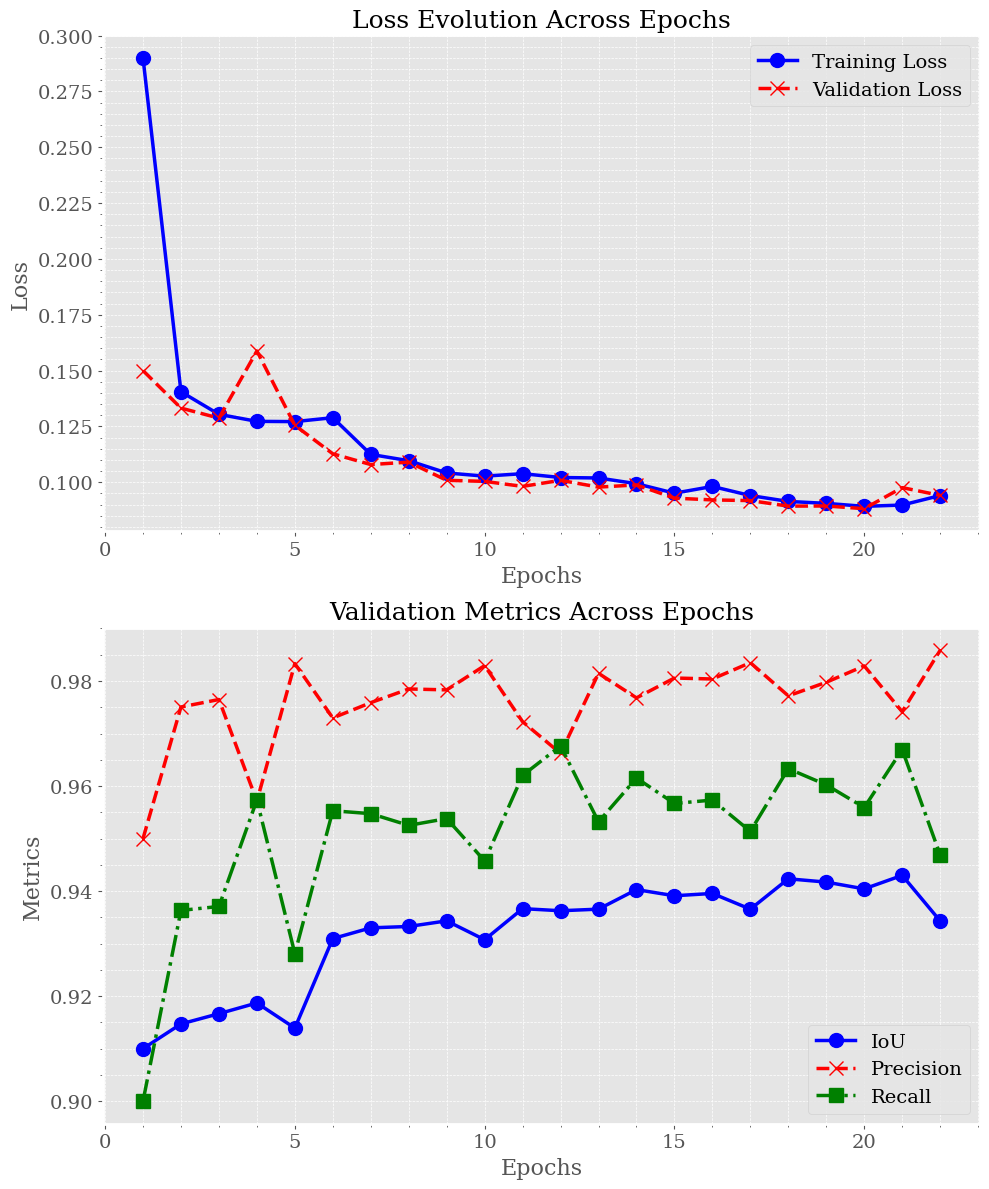

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import os

# Provided values for epoch 1
EPOCH_1_TRAIN_LOSS = 0.29
EPOCH_1_VAL_LOSS = 0.15

def extract_loss_metrics(log_lines):
    """Extracts loss metrics from the given log lines."""
    metrics = []
    for line in log_lines:
        if "Val Loss" in line:
            epoch = int(re.search(r'EPOCH: (\d+)/\d+', line).group(1))
            val_loss = float(re.search(r'Val Loss: ([\d.]+)', line).group(1))
            metrics.append([epoch, val_loss, 'Val Loss'])
        elif "Mean Loss" in line:
            epoch = int(re.search(r'EPOCH: (\d+)/\d+', line).group(1))
            train_loss = float(re.search(r'Mean Loss: ([\d.]+)', line).group(1))
            metrics.append([epoch, train_loss, 'Train Loss'])
    return metrics

def read_log_file(file_path):
    """Reads the content of the log file."""
    with open(file_path, 'r') as file:
        return file.readlines()

def combine_loss_metrics(log_paths):
    """Combines loss metrics from multiple log files."""
    all_metrics = []
    for path in log_paths:
        log_lines = read_log_file(path)
        all_metrics.extend(extract_loss_metrics(log_lines))
    return all_metrics

def create_loss_dataframe(metrics):
    """Creates DataFrame from the loss metrics."""
    df_loss = pd.DataFrame(metrics, columns=["Epoch", "Loss", "Type"])
    df_train_loss = df_loss[df_loss["Type"] == "Train Loss"].drop_duplicates(subset="Epoch").sort_values(by="Epoch")
    df_val_loss = df_loss[df_loss["Type"] == "Val Loss"].drop_duplicates(subset="Epoch").sort_values(by="Epoch")
    
    # Manually add the provided values for epoch 1
    df_train_loss = pd.concat([pd.DataFrame([[1, EPOCH_1_TRAIN_LOSS, 'Train Loss']], columns=df_train_loss.columns), df_train_loss], ignore_index=True)
    df_val_loss = pd.concat([pd.DataFrame([[1, EPOCH_1_VAL_LOSS, 'Val Loss']], columns=df_val_loss.columns), df_val_loss], ignore_index=True)

    # Ensure the epochs range from 1 to 22
    epochs_range = pd.DataFrame({'Epoch': list(range(1, 23))})

    # Merge DataFrames to ensure consistent epochs
    df_combined = pd.merge(epochs_range, df_train_loss, on="Epoch", how="left").merge(df_val_loss, on="Epoch", how="left", suffixes=('_train', '_val'))
    return df_combined

def plot_metrics(df_combined, epochs, iou, precision_epochs, recall_epochs):
    """Plots the training/validation loss and validation metrics."""
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    
    # Customization parameters
    title_fontsize = 18
    label_fontsize = 16
    tick_fontsize = 14
    legend_fontsize = 14
    line_width = 2.5
    marker_size = 10

    # Training/Validation Loss plot
    axes[0].plot(df_combined['Epoch'], df_combined['Loss_train'], marker='o', linestyle='-', color='b', label='Training Loss', linewidth=line_width, markersize=marker_size)
    axes[0].plot(df_combined['Epoch'], df_combined['Loss_val'], marker='x', linestyle='--', color='r', label='Validation Loss', linewidth=line_width, markersize=marker_size)
    axes[0].set_title('Loss Evolution Across Epochs', fontsize=title_fontsize)
    axes[0].set_xlabel('Epochs', fontsize=label_fontsize)
    axes[0].set_ylabel('Loss', fontsize=label_fontsize)
    axes[0].legend(fontsize=legend_fontsize)
    axes[0].grid(which='both', linestyle='--', linewidth=0.5)
    axes[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    axes[0].tick_params(axis='both', which='minor', labelsize=tick_fontsize)
    axes[0].minorticks_on()
    axes[0].spines['top'].set_linewidth(2)
    axes[0].spines['right'].set_linewidth(2)
    axes[0].spines['bottom'].set_linewidth(2)
    axes[0].spines['left'].set_linewidth(2)

    # Validation Metrics plot
    axes[1].plot(epochs, iou, marker='o', linestyle='-', color='b', label='IoU', linewidth=line_width, markersize=marker_size)
    axes[1].plot(epochs, precision_epochs, marker='x', linestyle='--', color='r', label='Precision', linewidth=line_width, markersize=marker_size)
    axes[1].plot(epochs, recall_epochs, marker='s', linestyle='-.', color='g', label='Recall', linewidth=line_width, markersize=marker_size)
    axes[1].set_title('Validation Metrics Across Epochs', fontsize=title_fontsize)
    axes[1].set_xlabel('Epochs', fontsize=label_fontsize)
    axes[1].set_ylabel('Metrics', fontsize=label_fontsize)
    axes[1].legend(fontsize=legend_fontsize)
    axes[1].grid(which='both', linestyle='--', linewidth=0.5)
    axes[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    axes[1].tick_params(axis='both', which='minor', labelsize=tick_fontsize)
    axes[1].minorticks_on()
    axes[1].spines['top'].set_linewidth(2)
    axes[1].spines['right'].set_linewidth(2)
    axes[1].spines['bottom'].set_linewidth(2)
    axes[1].spines['left'].set_linewidth(2)

    plt.tight_layout()

    # Save the combined plot
    if not os.path.exists('plots/training'):
        os.makedirs('plots/training')
    plt.savefig('plots/training/training_validation_metrics_combined.jpg', dpi=300)

    plt.show()

# File paths
log_paths = ['train copy.log', 'train.log']

# Combine and process loss metrics
all_loss_metrics = combine_loss_metrics(log_paths)
df_loss_combined = create_loss_dataframe(all_loss_metrics)

# Data for validation metrics
epochs = list(range(1, 23))
iou = [0.91, 0.914707, 0.916660, 0.918699, 0.913917, 0.930954, 0.933003, 0.933262, 0.934331, 0.930741, 0.936661, 0.936258, 0.936562, 0.940284, 0.939111, 0.939553, 0.936558, 0.942341, 0.941713, 0.940420, 0.942994, 0.934319]
precision_epochs = [0.95, 0.975052, 0.976476, 0.957124, 0.983308, 0.972965, 0.975878, 0.978484, 0.978311, 0.982931, 0.972256, 0.966213, 0.981463, 0.976788, 0.980571, 0.980384, 0.983494, 0.977174, 0.979757, 0.982874, 0.974158, 0.985832]
recall_epochs = [0.90, 0.936321, 0.937073, 0.957338, 0.928094, 0.955297, 0.954742, 0.952513, 0.953805, 0.945748, 0.962018, 0.967640, 0.953185, 0.961521, 0.956682, 0.957330, 0.951369, 0.963307, 0.960226, 0.955912, 0.966943, 0.946898]

# Plot the metrics
plot_metrics(df_loss_combined, epochs, iou, precision_epochs, recall_epochs)

## 6.3 Inference Results

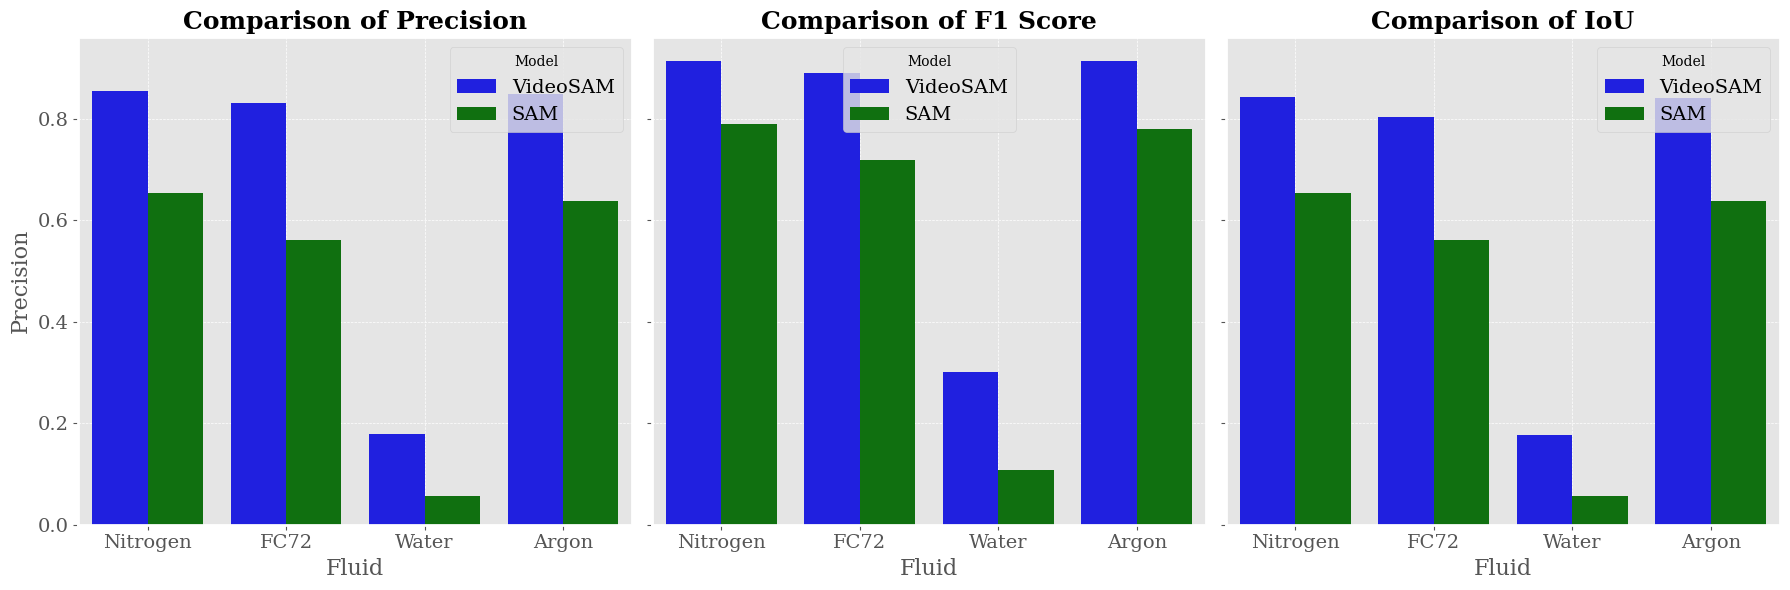

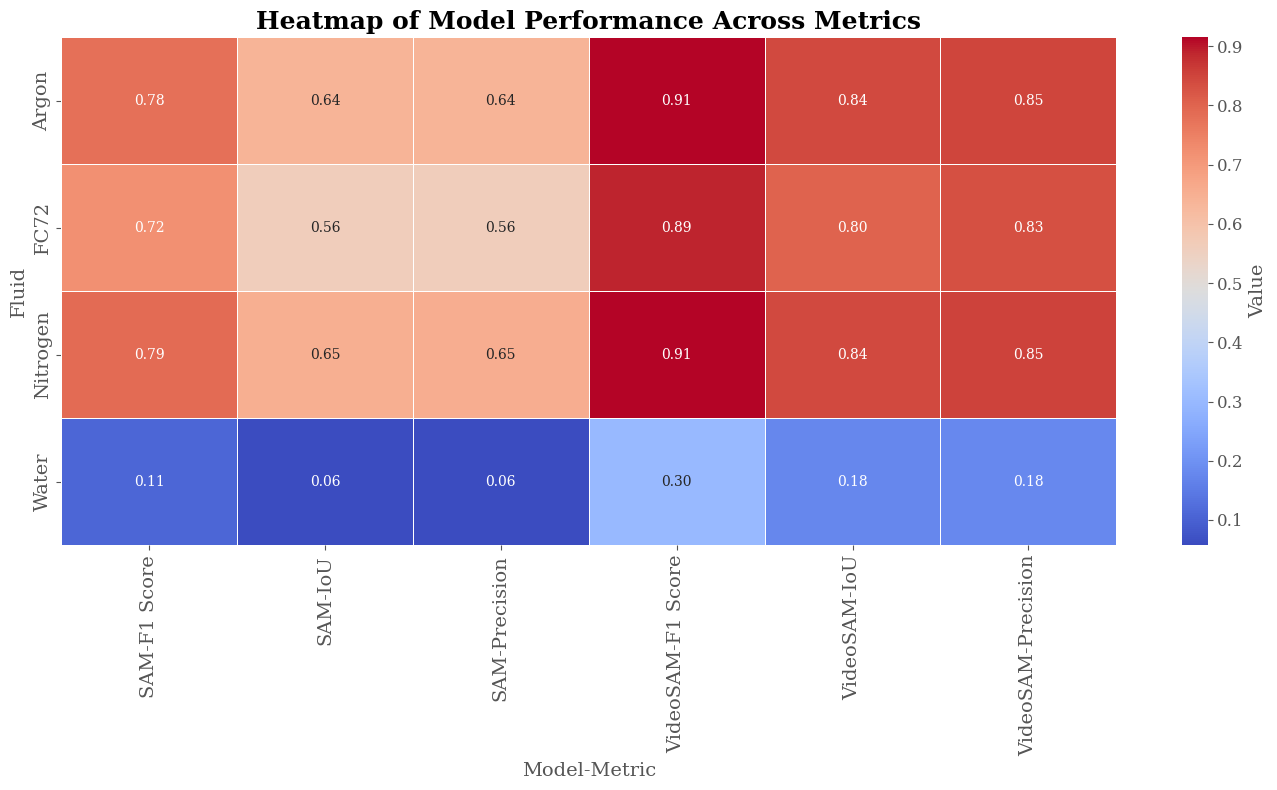

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the provided CSV file
file_path = 'plots/single_tiff/metrics_comparison_table.csv'
data = pd.read_csv(file_path)

# Define the directory and create it if it doesn't exist
output_dir = 'plots/single_tiff'
os.makedirs(output_dir, exist_ok=True)

# Define the metrics to visualize (only F1 Score, IoU, and Precision)
metrics = ["Precision", "F1 Score", "IoU"]

# Improved bar charts for metric comparison with scientifically appropriate colors
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Scientifically appropriate color palette
palette = {"VideoSAM": "blue", "SAM": "green"}

for i, metric in enumerate(metrics):
    sns.barplot(ax=axes[i], data=data, x='Fluid', y=metric, hue='Model', palette=palette)
    axes[i].set_title(f'Comparison of {metric}', fontsize=18, weight='bold')
    axes[i].set_xlabel('Fluid', fontsize=16)
    axes[i].set_ylabel(metric, fontsize=16)
    axes[i].legend(title='Model', fontsize=14)
    axes[i].tick_params(axis='both', which='major', labelsize=14)
    axes[i].tick_params(axis='both', which='minor', labelsize=12)
    axes[i].grid(True, linestyle='--', linewidth=0.5)
    axes[i].spines['top'].set_linewidth(2)
    axes[i].spines['right'].set_linewidth(2)
    axes[i].spines['bottom'].set_linewidth(2)
    axes[i].spines['left'].set_linewidth(2)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'bar_charts_comparison.jpg'), dpi=300)
plt.show()

# Corrected heatmap
heatmap_data = data.melt(id_vars=["Fluid", "Model"], var_name="Metric", value_name="Value")
heatmap_data = heatmap_data[heatmap_data['Metric'].isin(metrics)]
heatmap_pivot = heatmap_data.pivot_table(index=["Fluid", "Metric"], columns="Model", values="Value")
heatmap_pivot = heatmap_pivot.unstack(level='Metric')

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, cbar_kws={'label': 'Value'})
plt.title('Heatmap of Model Performance Across Metrics', fontsize=18, weight='bold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'heatmap_comparison.jpg'), dpi=300)
plt.show()

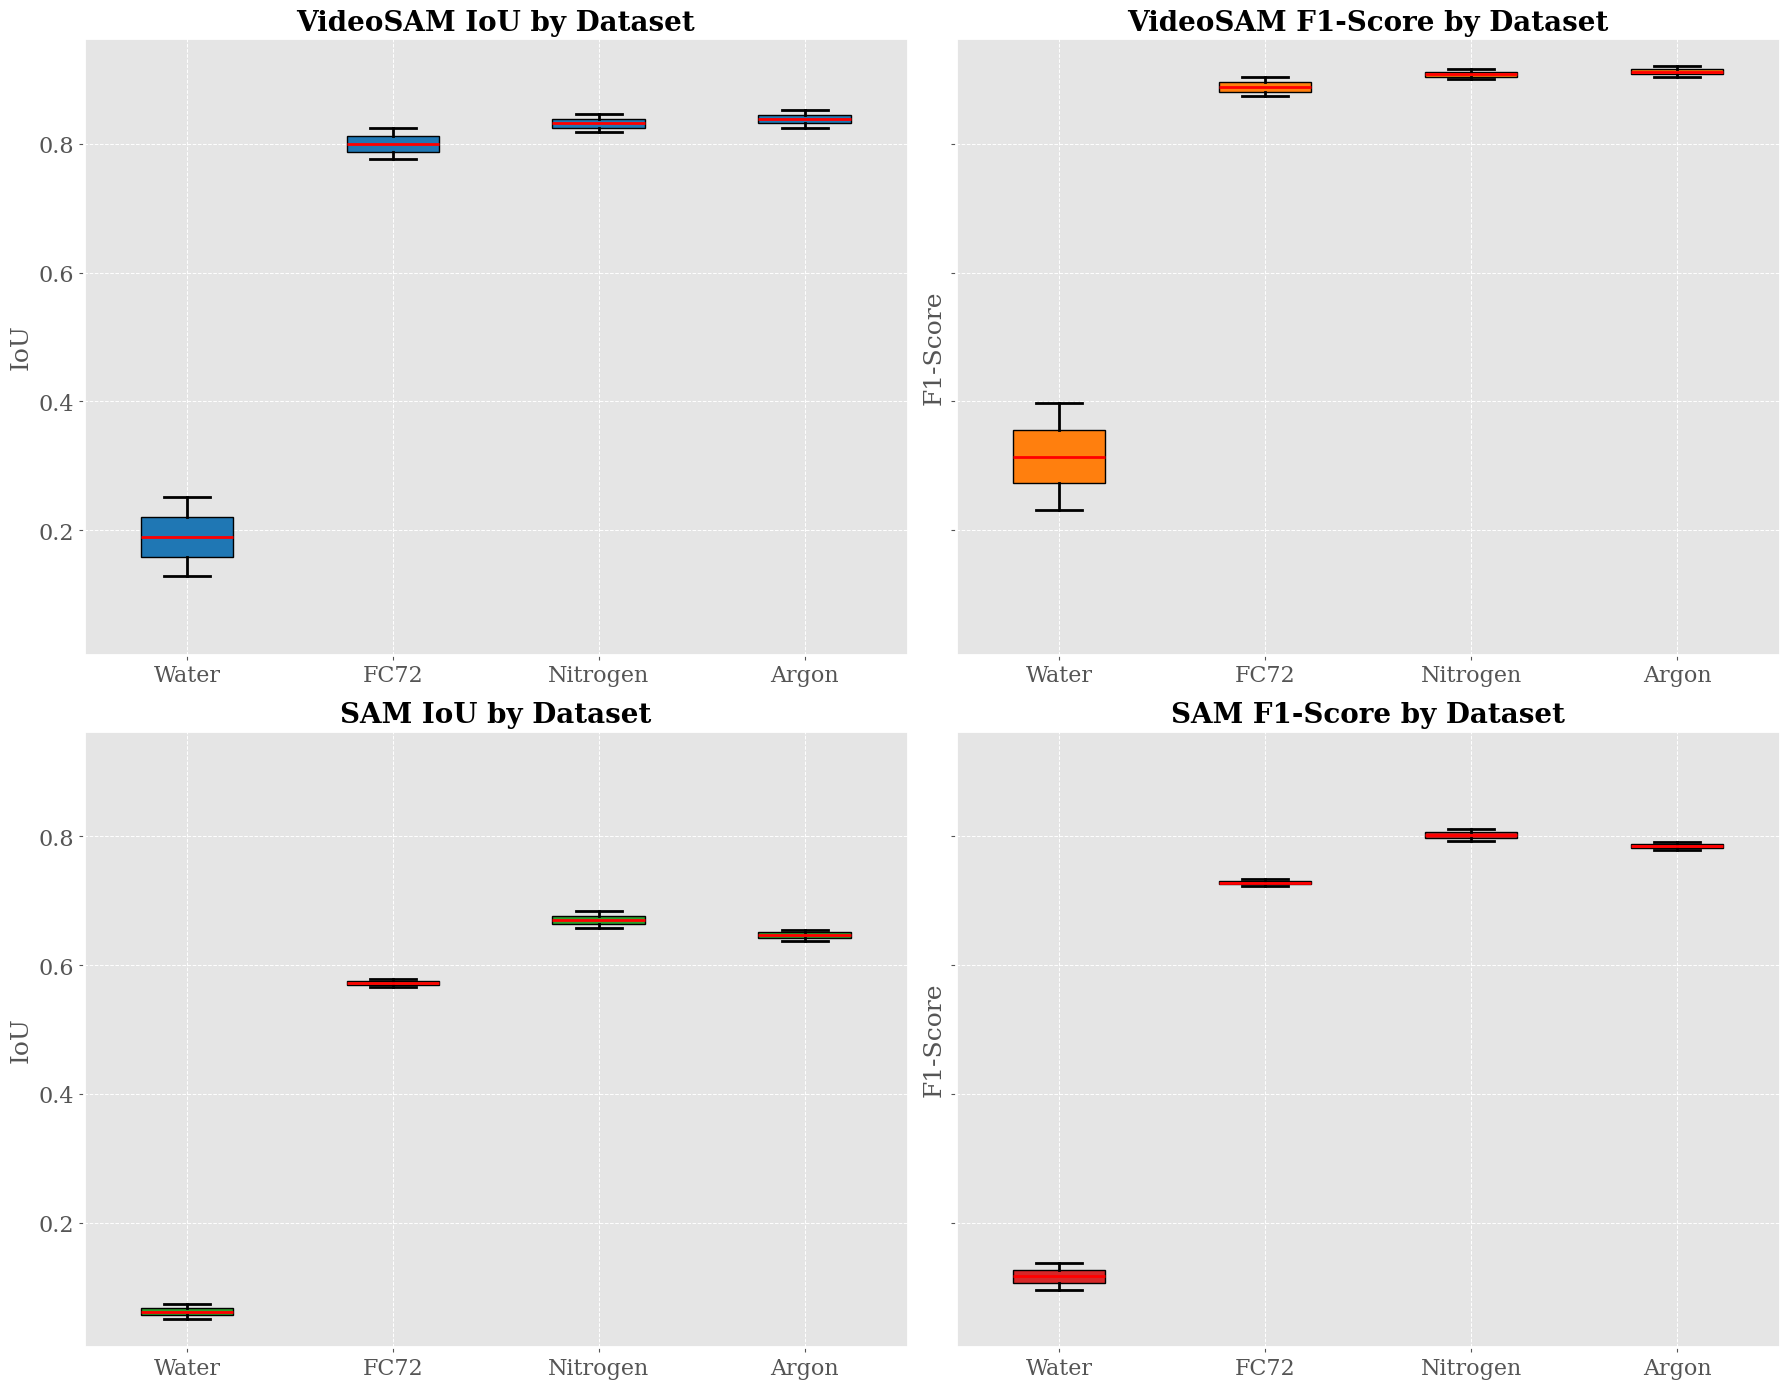

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure the directory exists
output_dir = 'plots/composite_tiff'
os.makedirs(output_dir, exist_ok=True)

# Load the dataset
file_path = os.path.join(output_dir, 'metrics_comparison_summary_table.csv')
data = pd.read_csv(file_path)

# Prepare data for box plot
def prepare_box_plot_data(metric_mean, metric_std):
    return {
        'Lower Whisker': metric_mean - metric_std,
        'Lower Quartile': metric_mean - 0.5 * metric_std,
        'Median': metric_mean,
        'Upper Quartile': metric_mean + 0.5 * metric_std,
        'Upper Whisker': metric_mean + metric_std
    }

# Collect data for each dataset
datasets = data['Fluid']
metrics = ['VideoSAM_IoU_Mean', 'VideoSAM_F1 Score_Mean', 'SAM_IoU_Mean', 'SAM_F1 Score_Mean']
std_devs = ['VideoSAM_IoU_StdDev', 'VideoSAM_F1 Score_StdDev', 'SAM_IoU_StdDev', 'SAM_F1 Score_StdDev']

# Initialize a dictionary to store the box plot data
box_plot_data = {metric: {dataset: {} for dataset in datasets} for metric in metrics}

# Populate the dictionary with the prepared box plot data
for metric, std_dev in zip(metrics, std_devs):
    for idx, dataset in enumerate(datasets):
        box_plot_data[metric][dataset] = prepare_box_plot_data(data[metric][idx], data[std_dev][idx])

# Define plot style
plt.style.use('ggplot')
plt.rcParams.update({
    "figure.figsize": (18, 14),
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "font.family": "serif"
})

# Custom color palette for better differentiation
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create box plots for each metric
fig, axes = plt.subplots(2, 2, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for ax, (metric, color) in zip(axes.flatten(), zip(metrics, colors)):
    # Extract the box plot values for each dataset
    box_values = [list(box_plot_data[metric][dataset].values()) for dataset in datasets]
    
    # Plot the box plot
    ax.boxplot(box_values, labels=datasets, patch_artist=True,
               boxprops=dict(facecolor=color, color='black'),
               medianprops=dict(color='red', linewidth=2),
               whiskerprops=dict(color='black', linewidth=2),
               capprops=dict(color='black', linewidth=2),
               flierprops=dict(marker='o', color='black', alpha=0.5))
    
    # Update title and ylabel
    metric_name = 'IoU' if 'IoU' in metric else 'F1-Score'
    ax.set_title(f'{metric.split("_")[0]} {metric_name} by Dataset', fontsize=20, weight='bold')
    ax.set_ylabel(metric_name, fontsize=18)
    ax.grid(True, linestyle='--', linewidth=0.7)
    
    # Enhance the border of the plot
    for spine in ax.spines.values():
        spine.set_linewidth(2)

# Adjust layout for better readability
plt.tight_layout()

# Save the plot as a 300 dpi JPEG file
output_path = os.path.join(output_dir, 'composite_frame_analysis.jpg')
plt.savefig(output_path, format='jpg', dpi=300)

# Show plot
plt.show()

## 6.4 Validation Analysis with U-Net CNN 

In [2]:
import numpy as np
import tifffile as tiff
import h5py
from sklearn.metrics import f1_score, jaccard_score
from tqdm import tqdm
from skimage.transform import resize

def normalize_unet_masks(masks):
    return (masks > 0).astype(np.float32)

# Load the U-Net mask and ground truth files
unet_mask_path = '/Users/chikamaduabuchi/Library/CloudStorage/GoogleDrive-sparkresearchers@gmail.com/My Drive/videosam/archived/u-net/masks/iter_50.tif'
gt_path = '/Users/chikamaduabuchi/Library/CloudStorage/GoogleDrive-sparkresearchers@gmail.com/My Drive/videosam/archived/data/test/test_mask.tif'

print("Loading U-Net mask and ground truth files...")
unet_mask = tiff.imread(unet_mask_path)
gt = tiff.imread(gt_path)

# Resize U-Net mask frames to match the ground truth frame size (256x256)
print("Resizing U-Net mask frames to 256x256...")
unet_mask_resized = np.zeros((unet_mask.shape[0], 256, 256), dtype=np.uint8)

for i in range(unet_mask.shape[0]):
    unet_mask_resized[i] = resize(unet_mask[i], (256, 256), order=0, preserve_range=True).astype(np.uint8)

# Normalize the U-Net masks and the ground truth
unet_mask_resized = normalize_unet_masks(unet_mask_resized)
gt = normalize_unet_masks(gt)

# Define the frame ranges for each fluid
frame_ranges = {
    'water': range(0, 250),
    'fc-72': range(250, 500),
    'nitrogen': range(500, 750),
    'argon': range(750, 1000)
}

# Initialize lists to store IoU and F1 scores for each model and fluid
metrics = ['IoU', 'F1 Score']
results = {fluid: {model: {metric: [] for metric in metrics} for model in ['U-Net']} for fluid in frame_ranges}
visuals = []

# Process the masks
for fluid, frames in frame_ranges.items():
    for i in tqdm(frames, desc=f"Processing {fluid} frames"):
        # Flatten the ground truth and U-Net masks for scoring
        gt_frame = gt[i].flatten()
        unet_mask_frame = unet_mask_resized[i].flatten()
        
        # Calculate IoU and F1 scores for U-Net
        if np.sum(gt_frame) > 0 and np.sum(unet_mask_frame) > 0:
            results[fluid]['U-Net']['IoU'].append(jaccard_score(gt_frame, unet_mask_frame, average='binary'))
            results[fluid]['U-Net']['F1 Score'].append(f1_score(gt_frame, unet_mask_frame, average='binary'))

        # Store visuals for summary
        if i % 250 == 0:
            visuals.append((gt[i], unet_mask_resized[i], i, fluid))

# Calculate mean IoU and F1 score for each model and fluid
mean_results = {fluid: {model: {metric: np.mean(results[fluid][model][metric]) if results[fluid][model][metric] else 0 for metric in metrics} for model in ['U-Net']} for fluid in frame_ranges}

# Output the results
print("Mean IoU and F1 Score per fluid and model:")
for fluid in frame_ranges:
    for model in ['U-Net']:
        print(f"{fluid} - {model}: Mean IoU = {mean_results[fluid][model]['IoU']:.4f}, Mean F1 = {mean_results[fluid][model]['F1 Score']:.4f}")


Loading U-Net mask and ground truth files...
Resizing U-Net mask frames to 256x256...


Processing argon frames: 100%|██████████| 250/250 [00:11<00:00, 20.91it/s]

Mean IoU and F1 Score per fluid and model:
water - U-Net: Mean IoU = 0.5619, Mean F1 = 0.7191
fc-72 - U-Net: Mean IoU = 0.7244, Mean F1 = 0.8400
nitrogen - U-Net: Mean IoU = 0.7547, Mean F1 = 0.8602
argon - U-Net: Mean IoU = 0.7815, Mean F1 = 0.8773


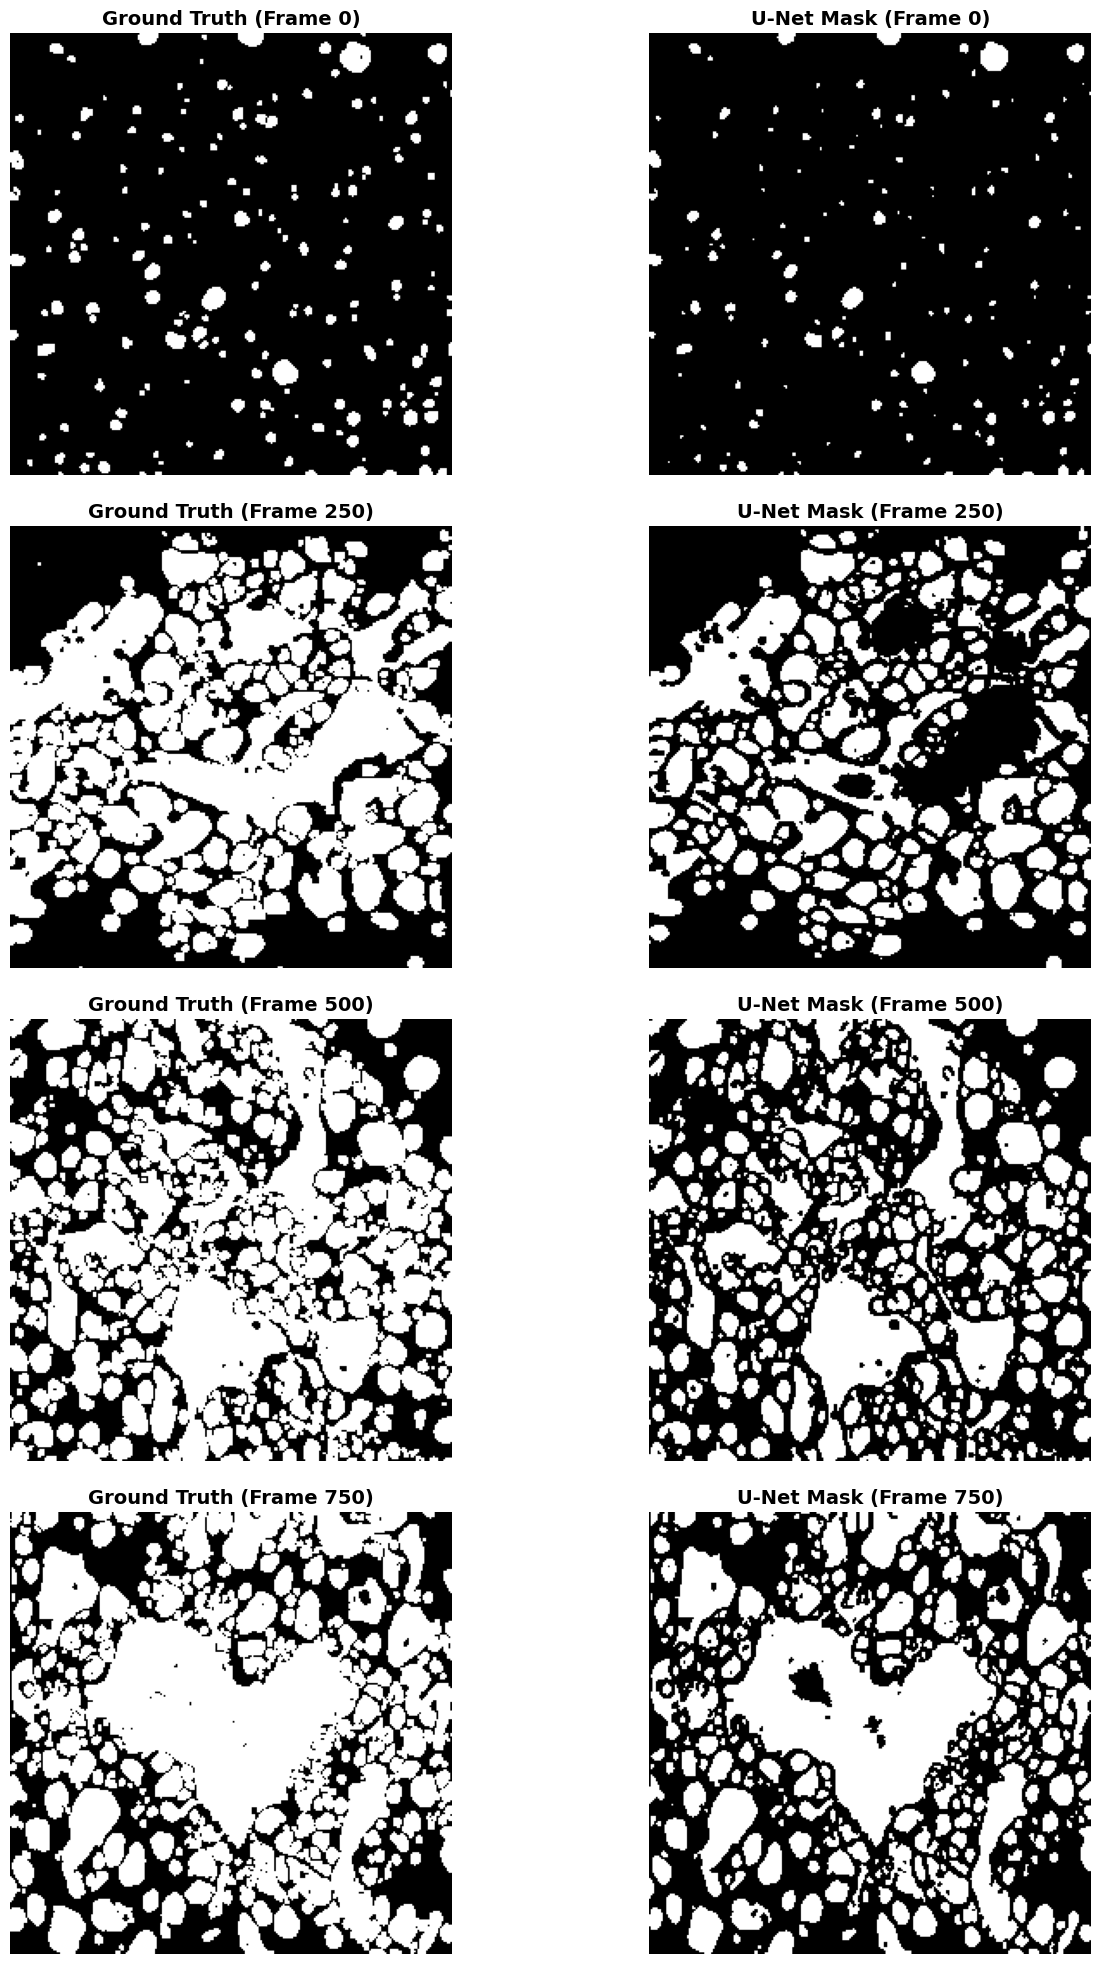

In [5]:
import matplotlib.pyplot as plt

def visualize_unet_vs_gt(visuals):
    fig, axs = plt.subplots(len(visuals), 2, figsize=(15, 5 * len(visuals)))

    for i, (gt, unet_mask, frame_index, fluid) in enumerate(visuals):
        # Ground Truth
        axs[i, 0].imshow(gt, cmap='gray')
        axs[i, 0].set_title(f'Ground Truth (Frame {frame_index})', fontsize=14, weight='bold')
        axs[i, 0].set_xlabel(f'{fluid.capitalize()}', fontsize=12)
        axs[i, 0].axis('off')
        
        # U-Net Mask
        axs[i, 1].imshow(unet_mask, cmap='gray')
        axs[i, 1].set_title(f'U-Net Mask (Frame {frame_index})', fontsize=14, weight='bold')
        axs[i, 1].set_xlabel(f'{fluid.capitalize()}', fontsize=12)
        axs[i, 1].axis('off')
    
    # Adjust layout to ensure titles and labels fit nicely
    plt.tight_layout(pad=2)
    plt.show()

# Visualize the collected masks
visualize_unet_vs_gt(visuals)


In [8]:
!pip install tabulate

In [9]:
import pandas as pd
from tabulate import tabulate

# Data from the results you provided
fluids = ['Water', 'FC-72', 'Nitrogen', 'Argon']

# U-Net Results
unet_iou = [0.5619, 0.7244, 0.7547, 0.7815]
unet_f1 = [0.7191, 0.8400, 0.8602, 0.8773]

# VideoSAM Results
videosam_iou = [0.189444, 0.799655, 0.831651, 0.838407]
videosam_f1 = [0.314252, 0.888476, 0.908027, 0.912041]

# Create a DataFrame for the results
data = {
    'Fluid': fluids,
    'U-Net Mean IoU': unet_iou,
    'VideoSAM Mean IoU': videosam_iou,
    'U-Net Mean F1 Score': unet_f1,
    'VideoSAM Mean F1 Score': videosam_f1
}

df = pd.DataFrame(data)

# Display the table using tabulate for better formatting
table = tabulate(df, headers='keys', tablefmt='pipe', showindex=False)
print(table)


| Fluid    |   U-Net Mean IoU |   VideoSAM Mean IoU |   U-Net Mean F1 Score |   VideoSAM Mean F1 Score |
|:---------|-----------------:|--------------------:|----------------------:|-------------------------:|
| Water    |           0.5619 |            0.189444 |                0.7191 |                 0.314252 |
| FC-72    |           0.7244 |            0.799655 |                0.84   |                 0.888476 |
| Nitrogen |           0.7547 |            0.831651 |                0.8602 |                 0.908027 |
| Argon    |           0.7815 |            0.838407 |                0.8773 |                 0.912041 |
